# Compositional analysis

## Motivation

Beyond changes in gene expression patterns, cell compositions, such as the proportions of cell-types, can change between conditions. A specific drug may, for example, induce a transdifferentiation of a cell type which will be reflected in the cell identity composition. Sufficient cell and sample numbers are required to accurately determine cell-identity cluster proportions and background variation. Compositional analysis can be done on the level of cell identity clusters in the form of known cell types or cell states corresponding to, for example, cells recently affected by perturbations.

:::{figure-md} Compositional analysis overview
<img src="../_static/images/conditions/compositional.jpg" alt="Compositional analysis overview" class="bg-primary mb-1" width="800px">

Differential abundance analysis compares the composition of cell types between two conditions. The samples from both modalities contain different proportions of cell types, which can be tested for significant shifts in abundance.
:::


This chapter will introduce both approaches and apply them to the Haber dataset{cite}`comp:Haber2017`. This dataset contains 53,193 individual epithelial cells from the small intestine and organoids of mice. Some of the cells were also subject to bacterial or helminth infection such as through Salmonella and Heligmosomoides polygyrus respectively.
Throughout this tutorial we are using a subset of the complete Haber dataset which only includes control and infected cells that were collected specifically for this purpose. Notably, we are excluding an additional dataset which collected only large cells for faster computation and reduced complexity.

As a first step, we load the dataset.

## Data loading

In [ ]:
import warnings

import pandas as pd

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pertpy as pt
import scanpy as sc
import seaborn as sns

In [2]:
adata = pt.dt.haber_2017_regions()

In [3]:
adata

AnnData object with n_obs × n_vars = 9842 × 15215
    obs: 'batch', 'barcode', 'condition', 'cell_label'

In [4]:
adata.obs

batch         barcode  \
index                                                                      
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor       B1  AAACATACCACAAC   
B1_AAACGCACGAGGAC_Control_Stem                        B1  AAACGCACGAGGAC   
B1_AAACGCACTAGCCA_Control_Stem                        B1  AAACGCACTAGCCA   
B1_AAACGCACTGTCCC_Control_Stem                        B1  AAACGCACTGTCCC   
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor       B1  AAACTTGACCACCT   
...                                                  ...             ...   
B10_TTTCACGACAAGCT_Salmonella_TA                     B10  TTTCACGACAAGCT   
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte             B10  TTTCAGTGAGGCGA   
B10_TTTCAGTGCGACAT_Salmonella_Stem                   B10  TTTCAGTGCGACAT   
B10_TTTCAGTGTGACCA_Salmonella_Endocrine              B10  TTTCAGTGTGACCA   
B10_TTTCAGTGTTCTCA_Salmonella_Enterocyte.Progen...   B10  TTTCAGTGTTCTCA   

                                                     condition  \
index                                                            
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor        Control   
B1_AAACGCACGAGGAC_Control_Stem                         Control   
B1_AAACGCACTAGCCA_Control_Stem                         Control   
B1_AAACGCACTGTCCC_Control_Stem                         Control   
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor        Control   
...                                                        ...   
B10_TTTCACGACAAGCT_Salmonella_TA                    Salmonella   
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte            Salmonella   
B10_TTTCAGTGCGACAT_Salmonella_Stem                  Salmonella   
B10_TTTCAGTGTGACCA_Salmonella_Endocrine             Salmonella   
B10_TTTCAGTGTTCTCA_Salmonella_Enterocyte.Progen...  Salmonella   

                                                               cell_label  
index                                                                      
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor     Enterocyte.Progenitor  
B1_AAACGCACGAGGAC_Control_Stem                                       Stem  
B1_AAACGCACTAGCCA_Control_Stem                                       Stem  
B1_AAACGCACTGTCCC_Control_Stem                                       Stem  
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor     Enterocyte.Progenitor  
...                                                                   ...  
B10_TTTCACGACAAGCT_Salmonella_TA                                       TA  
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte                       Enterocyte  
B10_TTTCAGTGCGACAT_Salmonella_Stem                                   Stem  
B10_TTTCAGTGTGACCA_Salmonella_Endocrine                         Endocrine  
B10_TTTCAGTGTTCTCA_Salmonella_Enterocyte.Progen...  Enterocyte.Progenitor  

[9842 rows x 4 columns]

The data was collected in 10 batches. Unique conditions are Control, Salmonella, Hpoly.Day3 and Hpoly.Day10 which correspond to the healthy control state, Salmonella infection, Heligmosomoides polygyrus infected cells after 3 days and Heligmosomoides polygyrus infected cells after 10 days. The `cell_label` corresponds to the cell types.

## Why cell-type count data is compositional

When analyzing the compositional shifts in cell count data, multiple technical and methodological limitations need to be accounted for. One challenge is the characteristically low number of experimental replicates, which leads to large confidence intervals when conducting differential abundance analysis with frequentist statistical tests.
Even more important, single-cell sequencing is naturally limited in the number of cells per sample - we can't sequence every cell in a tissue or organ, but use a small, representative snapshot instead. This, however, forces us to view the cell type counts as purely proportional, i.e. the total number of cells in a sample is only a scaling factor. In the statistical literature, such data is known as compositional data{cite}`Aitchison1982`, and characterized by the relative abundances of all features (cell types in our case) in one sample always adding up to one.

Because of this sum-to-one constraint, a negative correlation between the cell type abundances is induced. To illustrate this, let's consider the following example:

In a case-control study, we want to compare the cell type composition of a healthy and a diseased organ. In both cases, we have three cell types (A, B and C), but their abundances differ:
- The healthy organ consists of 2,000 cells of each type (6,000 cells total).
- The disease leads to a doubling of cell type A, while cell types B and C are not affected, so that the diseased organ has 8,000 cells.

In [5]:
healthy_tissue = [2000, 2000, 2000]
diseased_tissue = [4000, 2000, 2000]
example_data_global = pd.DataFrame(
    data=np.array([healthy_tissue, diseased_tissue]),
    index=[1, 2],
    columns=["A", "B", "C"],
)
example_data_global["Disease status"] = ["Healthy", "Diseased"]
example_data_global

A     B     C Disease status
1  2000  2000  2000        Healthy
2  4000  2000  2000       Diseased

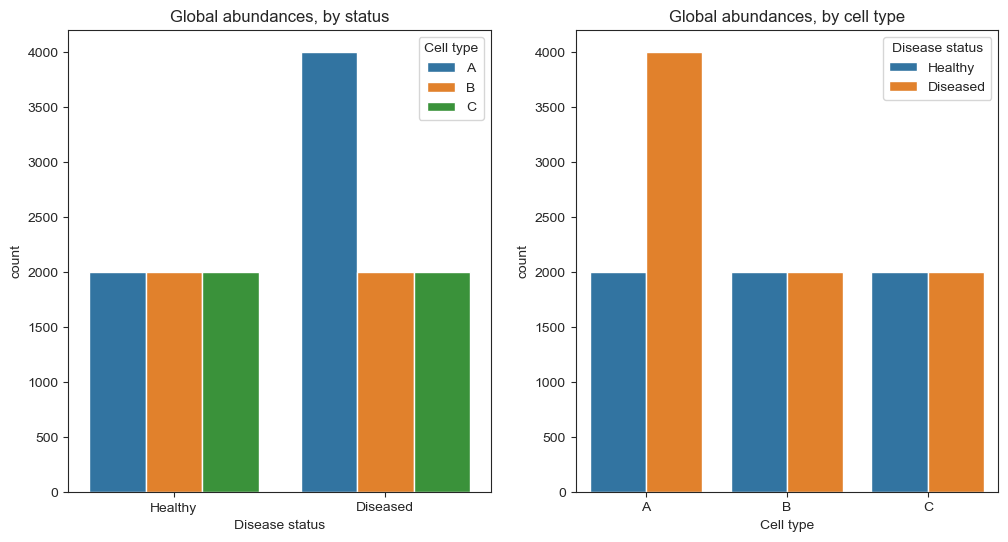

In [6]:
plot_data_global = example_data_global.melt(
    "Disease status", ["A", "B", "C"], "Cell type", "count"
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(
    data=plot_data_global, x="Disease status", y="count", hue="Cell type", ax=ax[0]
)
ax[0].set_title("Global abundances, by status")

sns.barplot(
    data=plot_data_global, x="Cell type", y="count", hue="Disease status", ax=ax[1]
)
ax[1].set_title("Global abundances, by cell type")

plt.show()


We want to find out which cell types increase or decrease in abundance in the diseased organ. If we are able to determine the type of every cell in both organs, the case would be clear, as we can see in the right plot above. Unfortunately, this is not possible. Since our sequencing process has a limited capacity, we can only take a representative sample of 600 cells from both populations. To simulate this step, we can use numpy's `random.multinomial` function to sample 600 cells from the populations without replacement:

In [7]:
rng = np.random.Generator(1234)
healthy_sample = rng.multinomial(pvals=healthy_tissue / np.sum(healthy_tissue), n=600)
diseased_sample = rng.multinomial(
    pvals=diseased_tissue / np.sum(diseased_tissue), n=600
)
example_data_sample = pd.DataFrame(
    data=np.array([healthy_sample, diseased_sample]),
    index=[1, 2],
    columns=["A", "B", "C"],
)
example_data_sample["Disease status"] = ["Healthy", "Diseased"]
example_data_sample

A    B    C Disease status
1  193  201  206        Healthy
2  296  146  158       Diseased

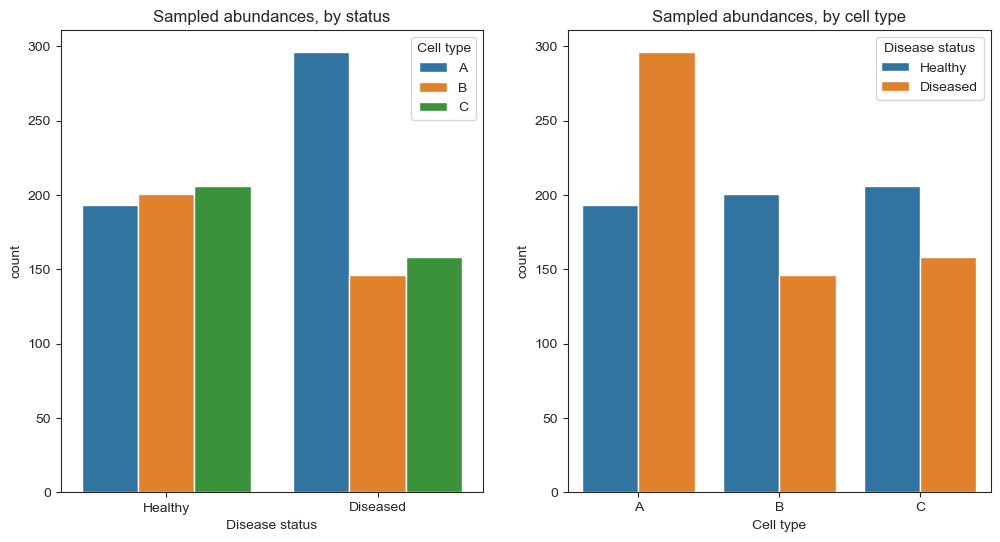

In [8]:
plot_data_sample = example_data_sample.melt(
    "Disease status", ["A", "B", "C"], "Cell type", "count"
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(
    data=plot_data_sample, x="Disease status", y="count", hue="Cell type", ax=ax[0]
)
ax[0].set_title("Sampled abundances, by status")

sns.barplot(
    data=plot_data_sample, x="Cell type", y="count", hue="Disease status", ax=ax[1]
)
ax[1].set_title("Sampled abundances, by cell type")
plt.show()

Now the picture is not clear anymore. While the counts of cell type A still increase (approx. from 200 to 300), the other two cell types seem to decrease from about 200 to 150. This apparent decrease is caused by our constraint to 600 cells - If a larger fraction of the sample is taken up by cell type A, the share of cell types B and C must be lower. Therefore, determining the change in abundance of one cell type is impossible without taking the other cell types into account.

If we ignore the compositionality of the data, and use univariate methods like Wilcoxon rank-sum tests or scDC, a method which performs differential cell-type composition analysis by bootstrap resampling{cite}`comp:Cao2019`, we may falsely perceive cell-type population shifts as statistically sound effects, although they were induced by inherent negative correlations of the cell-type proportions.

Furthermore, the subsampled data does not only give us one valid solution to our question. If both cell types B and C decreased by 1,000 cells in the diseased case, we would obtain the same representative samples of 600 cells as above. To get a unique result, we can fix a reference point for the data, which is assumed to be unchanged throughout all samples{cite}`Brill2019`. This can be a single cell type, an aggregation over multiple cell types such as the geometric mean, or a set of orthogonal bases {cite}`Egozcue2003`.

While single-cell datasets of sufficient size and replicate number have only been around for a few years, the same statistical property has also been discussed in the context of microbial analysis{cite}`Gloor2017`. There, some popular approaches include ANCOM-BC {cite}`Lin2020` and ALDEx2 {cite}`Fernandes2014`. However, these approaches often struggle with single-cell datasets due to the small number of experimental replicates.

This issue has been tackled by scCODA{cite}`Büttner2021`, which we are going to introduce and apply to our dataset in the following section.

## With labeled clusters

[scCODA](https://sccoda.readthedocs.io/en/latest) belongs to the family of tools that require pre-defined clusters, most common cell types, to statistically derive changes in composition. Inspired by methods for compositional analysis of microbiome data, scCODA proposes a Bayesian approach to address the low replicate issue as commonly encountered in single-cell analysis{cite}`Büttner2021`. It models cell-type counts using a hierarchical Dirichlet-Multinomial model, which accounts for uncertainty in cell-type proportions and the negative correlative bias via joint modeling of all measured cell-type proportions. To ensure a uniquely identifiable solution and easy interpretability, the reference in scCODA is chosen to be a specific cell type. Hence, any detected compositional changes by scCODA always have to be viewed in relation to the selected reference.

However, scCODA assumes a log-linear relationship between covariates and cell abundance, which may not always reflect the underlying biological processes when using continuous covariates. A further limitation of scCODA is the inability to infer correlation structures among cell compositions beyond compositional effects. Furthermore, scCODA only models shifts in mean abundance, but does not detect changes in response variability{cite}`Büttner2021`.

As a first step, we instantiate a scCODA model. 

Then, we use load function to prepare a MuData object for subsequent processing, and it creates a compositional analysis dataset from the input adata. And we specify the cell_type_identifier as `cell_label`, sample_identifier as `batch`, and covariate_obs as `condition` in our case.

In [9]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_label",
    sample_identifier="batch",
    covariate_obs=["condition"],
)
sccoda_data

MuData object with n_obs × n_vars = 9852 × 15223
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'scCODA_sample_id'
    coda:	10 x 8
      obs:	'condition', 'batch'
      var:	'n_cells'

To get an overview of the cell type distributions across conditions we can use scCODA's `boxplots`. To get an even better understanding of how the data is distributed, the red dots show the actual data points.

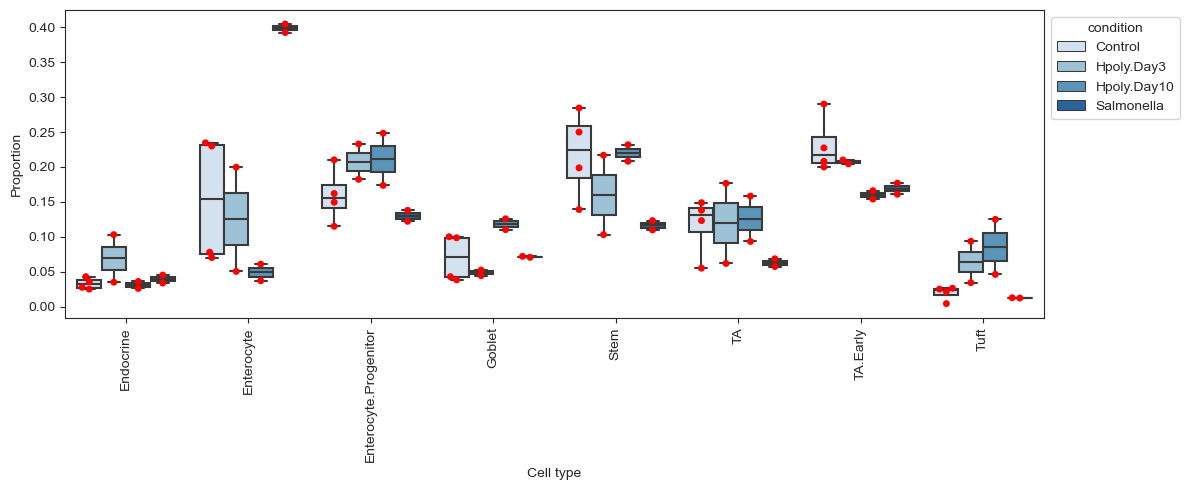

In [10]:
sccoda_model.plot_boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="condition",
    figsize=(12, 5),
    add_dots=True,
    args_swarmplot={"palette": ["red"]},
)
plt.show()

The boxplots highlight some differences in the distributions of the cell types. Clearly noticeable is the high proportion of enterocytes for the Salmonella condition. But other cell types such as transit-amplifying (TA) cells also show stark differences in abundance for the Salmonella condition compared to control. Whether any of these differences are statistically significant has to be properly evaluated.

An alternative visualization is a stacked barplot as provided by scCODA. This visualization nicely displays the characteristics of compositional data: If we compare the Control and Salmonella groups, we can see that the proportion of Enterocytes greatly increases in the infected mice. Since the data is proportional, this leads to a decreased share of all other cell types to fulfill the sum-to-one constraint.

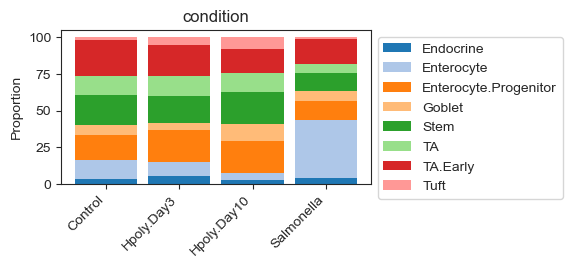

In [11]:
sccoda_model.plot_stacked_barplot(
    sccoda_data, modality_key="coda", feature_name="condition", figsize=(4, 2)
)
plt.show()

scCODA requires two major parameters beyond the cell count AnnData object: A formula and a reference cell type. The formula describes the covariates, which are specified using the [R-style](https://www.statsmodels.org/stable/example_formulas.html). In our case we specify the condition as the only covariate. Since it is a discrete covariate with four levels (control and three disease states), this models a comparison of each state with the other samples.
If we wanted to model multiple covariates at once, simply adding them in the formula (i.e. `formula = "covariate_1 + covariate_2"`) is enough.
As mentioned above, scCODA requires a reference cell type to compare against, which is believed to be unchanged by the covariates. scCODA can either automatically select an appropriate cell type as reference, which is a cell type that has nearly constant relative abundance over all samples, or be run with a user specified reference cell type. Here we set Endocrine cells as the reference since visually their abundance seems to be rather constant. An alternative to setting a reference cell type manually is to set the `reference_cell_type` to `"automatic"` which will force scCODA to select a suitable reference cell type itself. If the choice of reference cell type is unclear, we recommend to use this option to get an indicator or even a final selection.

In [12]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="condition",
    reference_cell_type="Endocrine",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

sample: 100%|██████████| 11000/11000 [01:08<00:00, 161.54it/s, 255 steps of size 1.72e-02. acc. prob=0.85]


In [13]:
sccoda_data["coda"].varm["effect_df_condition[T.Salmonella]"]

Final Parameter  HDI 3%  HDI 97%     SD  \
Cell Type                                                        
Endocrine                       0.0000   0.000    0.000  0.000   
Enterocyte                      1.5458   0.985    2.071  0.283   
Enterocyte.Progenitor           0.0000  -0.475    0.566  0.143   
Goblet                          0.0000  -0.345    1.013  0.290   
Stem                            0.0000  -0.742    0.297  0.173   
TA                              0.0000  -0.876    0.331  0.211   
TA.Early                        0.0000  -0.338    0.615  0.151   
Tuft                            0.0000  -1.221    0.548  0.342   

                       Inclusion probability  Expected Sample  \
Cell Type                                                       
Endocrine                             0.0000        32.598994   
Enterocyte                            0.9996       382.634978   
Enterocyte.Progenitor                 0.2817       126.126003   
Goblet                                0.4354        52.735108   
Stem                                  0.3092       135.406509   
TA                                    0.3358        78.986854   
TA.Early                              0.3033       152.670412   
Tuft                                  0.4098        23.041143   

                       log2-fold change  
Cell Type                                
Endocrine                     -0.526812  
Enterocyte                     1.703306  
Enterocyte.Progenitor         -0.526812  
Goblet                        -0.526812  
Stem                          -0.526812  
TA                            -0.526812  
TA.Early                      -0.526812  
Tuft                          -0.526812

The acceptance rate describes the fraction of proposed samples that are accepted after the initial burn-in phase, and can be an ad-hoc indicator for a bad optimization run. In the case of scCODA, the desired acceptance rate is between 0.4 and 0.9. Acceptance rates that are way higher or too low indicate issues with the sampling process.

In [14]:
sccoda_data

MuData object with n_obs × n_vars = 9852 × 15223
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'scCODA_sample_id'
    coda:	10 x 8
      obs:	'condition', 'batch'
      var:	'n_cells'
      uns:	'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'
      varm:	'intercept_df', 'effect_df_condition[T.Hpoly.Day3]', 'effect_df_condition[T.Hpoly.Day10]', 'effect_df_condition[T.Salmonella]'

scCODA selects credible effects based on their inclusion probability. The cutoff between credible and non-credible effects depends on the desired false discovery rate (FDR). A smaller FDR value will produce more conservative results, but might miss some effects, while a larger FDR value selects more effects at the cost of a larger number of false discoveries.
The desired FDR level can be easily set after inference via sim_results.set_fdr(). Per default, the value is 0.05. Since, depending on the dataset, the FDR can have a major influence on the result, we recommend to try out different FDRs up to 0.2 to get the most prominent effects.

In our case, we use less strict FDR of 0.2.

In [15]:
sccoda_model.set_fdr(sccoda_data, 0.2)

To get the binary classification of compositional changes per cell type we use the `credible_effects` function of scCODA on the result object. Every cell type labeled as "True" is significantly more or less present. The fold-changes describe whether the cell type is more or less present. Hence, we will plot them alongside the binary classification below.

In [16]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate                 Cell Type            
condition[T.Hpoly.Day3]   Endocrine                False
                          Enterocyte               False
                          Enterocyte.Progenitor    False
                          Goblet                   False
                          Stem                     False
                          TA                       False
                          TA.Early                 False
                          Tuft                     False
condition[T.Hpoly.Day10]  Endocrine                False
                          Enterocyte                True
                          Enterocyte.Progenitor    False
                          Goblet                   False
                          Stem                     False
                          TA                       False
                          TA.Early                 False
                          Tuft                      True
condition[T.Salmonella]   Endocrine     

To plot the fold changes together with the binary classification, we can easily use effects_bar_plot function.

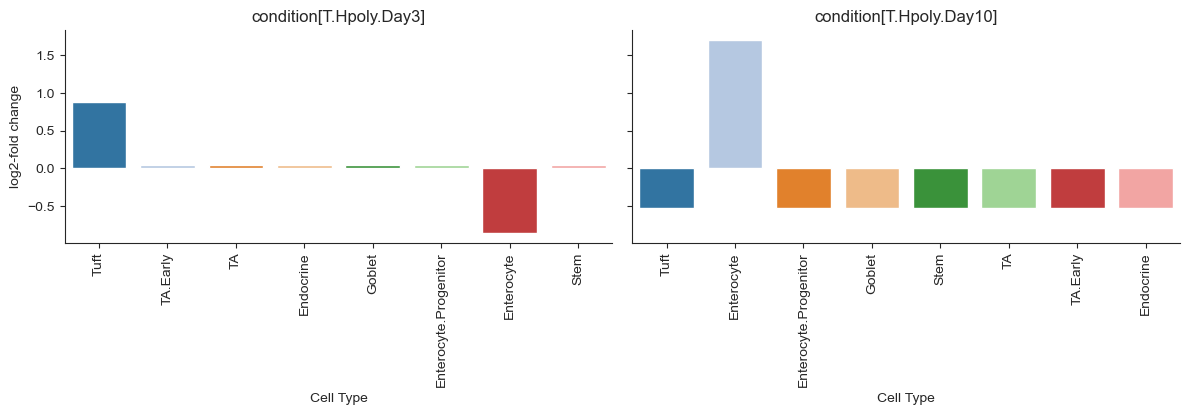

In [17]:
sccoda_model.plot_effects_barplot(sccoda_data, "coda", "condition")
plt.show()

The plots nicely show the significant and credible effects of conditions on the cell types. These effects largely agree with the findings in the Haber paper, who used a non-compositional Poisson regression model their findings:

1. "After Salmonella infection, the frequency of mature enterocytes increased substantially."{cite}`comp:Haber2017`
2. "Heligmosomoides polygyrus caused an increase in the abundance of goblet and tuft cells."{cite}`comp:Haber2017`

Readers familiar with the original publication may wonder why the model used by Haber et al. found more significant effects than scCODA, for example a decrease in Stem and Transit-Amplifying cells in the case of Salmonella infection{cite}`comp:Haber2017`. To explain this discrepancy, remember that cell count data is compositional and therefore an increase in the relative abundance of one cell type will lead to a decrease in the relative abundance of all other cell types.
Due to the stark increase of Enterocytes in the small intestinal epithelium of Salmonella-infected mice, all other cell types appear to decrease, even though this shift is only caused by the compositional properties of the data. While the original (univariate) Poisson regression model will pick up these likely false positive effects, scCODA is able to account for the compositionality of the data and therefore does not fall into this trap.

## With labeled clusters and hierarchical structure

In addition to the abundance of each cell type, a typical single-cell dataset also contains information about the similarity of the different cells in the form of a tree-based hierarchical ordering. These hierarchies can either be determined automatically via clustering of the gene expression (which is usually done to discover the clusters of cells that belong to the same cell type), or through biologically informed hierarchies like cell lineages.
[tascCODA](https://tasccoda.readthedocs.io/en/latest/) is an extension of scCODA that integrates hierarchical information and experimental covariate data into the generative modeling of compositional count data{cite}`Ostner2021`. This is especially beneficial for cell atlassing efforts with increased resolution.

At its core, it uses almost the same Dirichlet-Multinomial setup as scCODA, but extends the model, such that effects on sets of cell types, which are defined as internal nodes in the tree structure.

In [18]:
import schist

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

objc[13344]: Class GNotificationCenterDelegate is implemented in both /opt/anaconda3/lib/libgio-2.0.0.dylib (0x18ef5ec30) and /usr/local/Cellar/glib/2.74.4/lib/libgio-2.0.0.dylib (0x19be736b0). One of the two will be used. Which one is undefined.


To use tascCODA, we first have to define a hierarchical ordering of the cell types. One possible hierarchical clustering uses the eight cell types and orders them by their similarity (pearson correlation) in the PCA representation with `sc.tl.dendrogram`.
Since this structure is very simple in our data and will therefore not give us many new insights, we want to have a more complex clustering. One recent method to get such clusters, is the [schist](https://github.com/dawe/schist) package {cite}`Morelli2021`, which uses a nested stochastic block model that clusters the cell population at different resolution levels. Running the method with standard settings takes some time (~15 minutes on our data), and gives us an assignment of each cell to a hierarchical clustering in `adata.obs`.
First, we need to define a distance measure between the cells through a PCA embedding:

In [19]:
# use logcounts to calculate PCA and neighbors
adata.layers["counts"] = adata.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers["counts"]).copy()
adata.X = adata.layers["logcounts"].copy()
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, random_state=1234)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


Then, we can run schist on the AnnData object, which results in a clustering that is defined through a set of columns "nsbm_level_{i}" in `adata.obs`:

In [20]:
schist.inference.nested_model(adata, samples=100, random_seed=5678)
adata.obs

objc[13409]: Class GNotificationCenterDelegate is implemented in both /opt/anaconda3/lib/libgio-2.0.0.dylib (0x12f0f1c30) and /usr/local/Cellar/glib/2.74.4/lib/libgio-2.0.0.dylib (0x1448ce6b0). One of the two will be used. Which one is undefined.
objc[13410]: Class GNotificationCenterDelegate is implemented in both /opt/anaconda3/lib/libgio-2.0.0.dylib (0x1265f3c30) and /usr/local/Cellar/glib/2.74.4/lib/libgio-2.0.0.dylib (0x13bdb76b0). One of the two will be used. Which one is undefined.
objc[13408]: Class GNotificationCenterDelegate is implemented in both /opt/anaconda3/lib/libgio-2.0.0.dylib (0x125a9ec30) and /usr/local/Cellar/glib/2.74.4/lib/libgio-2.0.0.dylib (0x13b1576b0). One of the two will be used. Which one is undefined.
objc[13411]: Class GNotificationCenterDelegate is implemented in both /opt/anaconda3/lib/libgio-2.0.0.dylib (0x129969c30) and /usr/local/Cellar/glib/2.74.4/lib/libgio-2.0.0.dylib (0x13f0d36b0). One of the two will be used. Which one is undefined.
objc[13407]:

batch         barcode  \
index                                                                      
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor       B1  AAACATACCACAAC   
B1_AAACGCACGAGGAC_Control_Stem                        B1  AAACGCACGAGGAC   
B1_AAACGCACTAGCCA_Control_Stem                        B1  AAACGCACTAGCCA   
B1_AAACGCACTGTCCC_Control_Stem                        B1  AAACGCACTGTCCC   
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor       B1  AAACTTGACCACCT   
...                                                  ...             ...   
B10_TTTCACGACAAGCT_Salmonella_TA                     B10  TTTCACGACAAGCT   
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte             B10  TTTCAGTGAGGCGA   
B10_TTTCAGTGCGACAT_Salmonella_Stem                   B10  TTTCAGTGCGACAT   
B10_TTTCAGTGTGACCA_Salmonella_Endocrine              B10  TTTCAGTGTGACCA   
B10_TTTCAGTGTTCTCA_Salmonella_Enterocyte.Progen...   B10  TTTCAGTGTTCTCA   

                                                     condition  \
index                                                            
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor        Control   
B1_AAACGCACGAGGAC_Control_Stem                         Control   
B1_AAACGCACTAGCCA_Control_Stem                         Control   
B1_AAACGCACTGTCCC_Control_Stem                         Control   
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor        Control   
...                                                        ...   
B10_TTTCACGACAAGCT_Salmonella_TA                    Salmonella   
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte            Salmonella   
B10_TTTCAGTGCGACAT_Salmonella_Stem                  Salmonella   
B10_TTTCAGTGTGACCA_Salmonella_Endocrine             Salmonella   
B10_TTTCAGTGTTCTCA_Salmonella_Enterocyte.Progen...  Salmonella   

                                                               cell_label  \
index                                                                       
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor     Enterocyte.Progenitor   
B1_AAACGCACGAGGAC_Control_Stem                                       Stem   
B1_AAACGCACTAGCCA_Control_Stem                                       Stem   
B1_AAACGCACTGTCCC_Control_Stem                                       Stem   
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor     Enterocyte.Progenitor   
...                                                                   ...   
B10_TTTCACGACAAGCT_Salmonella_TA                                       TA   
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte                       Enterocyte   
B10_TTTCAGTGCGACAT_Salmonella_Stem                                   Stem   
B10_TTTCAGTGTGACCA_Salmonella_Endocrine                         Endocrine   
B10_TTTCAGTGTTCTCA_Salmonella_Enterocyte.Progen...  Enterocyte.Progenitor   

                                                   scCODA_sample_id  \
index                                                                 
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor                  B1   
B1_AAACGCACGAGGAC_Control_Stem                                   B1   
B1_AAACGCACTAGCCA_Control_Stem                                   B1   
B1_AAACGCACTGTCCC_Control_Stem                                   B1   
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor                  B1   
...                                                             ...   
B10_TTTCACGACAAGCT_Salmonella_TA                                B10   
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte                        B10   
B10_TTTCAGTGCGACAT_Salmonella_Stem                              B10   
B10_TTTCAGTGTGACCA_Salmonella_Endocrine                         B10   
B10_TTTCAGTGTTCTCA_Salmonella_Enterocyte.Progen...              B10   

                                                   nsbm_level_0 nsbm_level_1  \
index                                                                          
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor               0            0   
B1_AAACGCACGAGGAC_Control_Stem       

A UMAP plot nicely shows how the clustering from schist (here on levels 1 and 2) is connected to the cell type assignments. The representation on level 1 of the hierarchy is hereby a strict refinement of the level above, i.e. each cluster from level 2 is split into multiple smaller clusters:

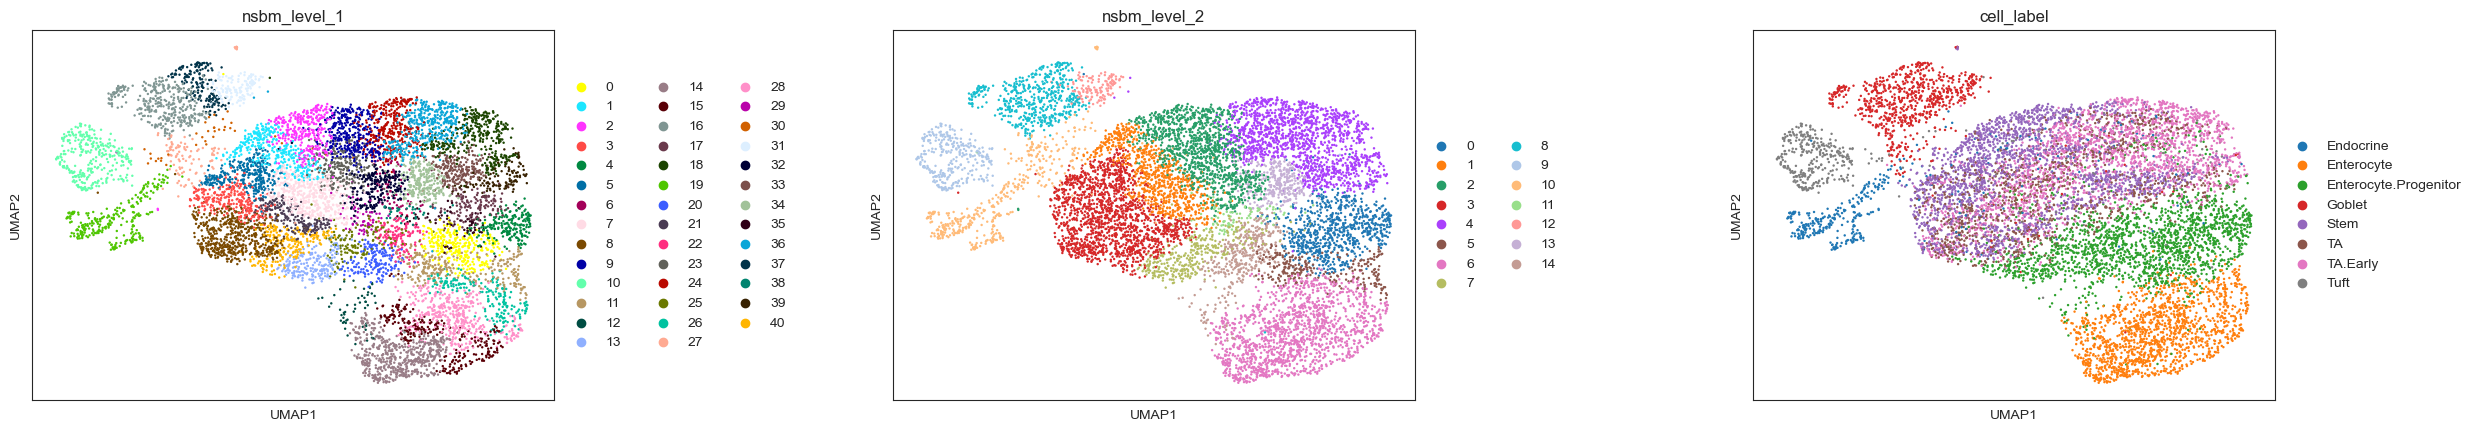

In [21]:
sc.pl.umap(
    adata, color=["nsbm_level_1", "nsbm_level_2", "cell_label"], ncols=3, wspace=0.5
)

Now, we convert our cell-level data to sample-level data and create the tree. We create a tasccoda_model object in the same way as for scCODA, but with the clustering defined by schist and tree levels.

The load function of Tasccoda will prepare a MuData object and it converts our tree representation into a [ete](http://etetoolkit.org/) tree structure and save it as `tasccoda_data['coda'].uns["tree"]`. To get some clusters that are not too small, we cut the tree before the last level by leaving out `"nsbm_level_0"`.

In [22]:
tasccoda_model = pt.tl.Tasccoda()
tasccoda_data = tasccoda_model.load(
    adata,
    type="cell_level",
    cell_type_identifier="nsbm_level_1",
    sample_identifier="batch",
    covariate_obs=["condition"],
    levels_orig=["nsbm_level_4", "nsbm_level_3", "nsbm_level_2", "nsbm_level_1"],
    add_level_name=True,
)
tasccoda_data

MuData object with n_obs × n_vars = 9852 × 15256
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'scCODA_sample_id', 'nsbm_level_0', 'nsbm_level_1', 'nsbm_level_2', 'nsbm_level_3', 'nsbm_level_4', 'nsbm_level_5'
      uns:	'neighbors', 'umap', 'schist', 'nsbm_level_1_colors', 'nsbm_level_2_colors', 'cell_label_colors'
      obsm:	'X_pca', 'X_umap', 'CM_nsbm_level_0', 'CM_nsbm_level_1', 'CM_nsbm_level_2', 'CM_nsbm_level_3', 'CM_nsbm_level_4', 'CM_nsbm_level_5'
      layers:	'counts', 'logcounts'
      obsp:	'distances', 'connectivities'
    coda:	10 x 41
      obs:	'condition', 'batch'
      var:	'n_cells'
      uns:	'tree'

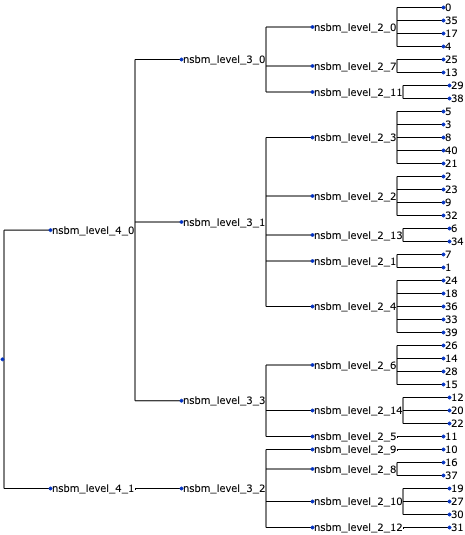

In [23]:
tasccoda_model.plot_draw_tree(tasccoda_data)

The model setup and execution in tascCODA works analogous to scCODA, and also the free parameters for the reference and the formula are the same. Additionally, we can adjust the tree aggregation and model selection via the parameters `phi` and `lambda_1` in the `pen_args` argument (see {cite}`Ostner2021` for more information). Here, we use an unbiased setting `phi=0` and a model selection that is slightly less strict than the default with `lambda_1=1.7`. We use cluster 18 as our reference, since it is almost identical to the set of Endocrine cells.

In [24]:
tasccoda_model.prepare(
    tasccoda_data,
    modality_key="coda",
    reference_cell_type="18",
    formula="condition",
    pen_args={"phi": 0, "lambda_1": 3.5},
    tree_key="tree",
)

Zero counts encountered in data! Added a pseudocount of 0.5.

MuData object with n_obs × n_vars = 9852 × 15256
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'scCODA_sample_id', 'nsbm_level_0', 'nsbm_level_1', 'nsbm_level_2', 'nsbm_level_3', 'nsbm_level_4', 'nsbm_level_5'
      uns:	'neighbors', 'umap', 'schist', 'nsbm_level_1_colors', 'nsbm_level_2_colors', 'cell_label_colors'
      obsm:	'X_pca', 'X_umap', 'CM_nsbm_level_0', 'CM_nsbm_level_1', 'CM_nsbm_level_2', 'CM_nsbm_level_3', 'CM_nsbm_level_4', 'CM_nsbm_level_5'
      layers:	'counts', 'logcounts'
      obsp:	'distances', 'connectivities'
    coda:	10 x 41
      obs:	'condition', 'batch'
      var:	'n_cells'
      uns:	'tree', 'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'

In [25]:
tasccoda_model.run_nuts(
    tasccoda_data, modality_key="coda", rng_key=1234, num_samples=10000, num_warmup=1000
)

sample: 100%|██████████| 11000/11000 [04:50<00:00, 37.83it/s, 127 steps of size 3.18e-02. acc. prob=0.97]


In [26]:
tasccoda_model.summary(tasccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────┐
│ Name                                       │ Value                                                              │
├────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Data                                       │ Data: 10 samples, 41 cell types                                    │
│ Reference cell type                        │ 18                                                                 │
│ Formula                                    │ condition                                                          │
└────────────────────────────────────────────┴────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            Final Parameter  Expected Sample                                                                     │
│ Cell Type                                                                                                       │
│ 0               1.313           53.195                                                                          │
│ 1               1.098           42.904                                                                          │
│ 2               1.205           47.749                                                                          │
│ 3               0.526           24.215                                                                          │
│ 4              -0.707            7.057                                                                          │
│ 5               0.634           26.976                                                                          │
│ 6              -0.432            9.290                                                                          │
│ 7               1.038           40.405                                                                          │
│ 8               1.276           51.263                                                                          │
│ 9               1.345           54.925                                                                          │
│ 10              0.625           26.735                                                                          │
│ 11              0.817           32.394                                                                          │
│ 12             -0.359            9.994                                                                          │
│ 13              0.260           18.559                                                                          │
│ 14              0.851           33.514                                                                          │
│ 15              0.524           24.166                                                                          │
│ 16              0.934           36.414                                                                          │
│ 17             -0.142           12.416                                                                          │
│ 18              0.684           28.360                                                                          │
│ 19              0.857           33.716                                                                          │
│ 20              0.198           17.443                                                                          │
│ 21              0.209           17.636                                                                          │
│ 22             -0.159           12.206                                                                          │
│ 23              0.913           35.658                                                                          │
│ 24              1.190           47.038                                                                          │
│ 25              0.057           15.149                                                                          │
│ 26             -0.086           13.131                                                                          │
│ 27             -0.002           14.281                                                                          │
│ 28              0.786           31.405                                                                          │
│ 29             -0.589            7.940                

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                   Effect  Expected Sample  log2-fold change                                     │
│ Covariate              Cell Type                                                                                │
│ conditionT.Hpoly.Day3  0           0.000      51.027            -0.060                                          │
│                        1           0.000      41.155            -0.060                                          │
│                        2          -0.257      35.423            -0.431                                          │
│                        3           0.439      36.030             0.573                                          │
│                        4           0.000       6.769            -0.060                                          │
│                        5           0.439      40.139             0.573                                          │
│                        6           0.000       8.912            -0.060                                          │
│                        7           0.000      38.759            -0.060                                          │
│                        8           0.439      76.276             0.573                                          │
│                        9          -0.257      40.746            -0.431                                          │
│                        10          0.000      25.645            -0.060                                          │
│                        11          0.000      31.073            -0.060                                          │
│                        12          0.000       9.586            -0.060                                          │
│                        13          0.000      17.803            -0.060                                          │
│                        14          0.000      32.148            -0.060                                          │
│                        15          0.000      23.181            -0.060                                          │
│                        16          0.000      34.930            -0.060                                          │
│                        17          0.000      11.910            -0.060                                          │
│                        18          0.000      27.204            -0.060                                          │
│                        19          0.000      32.342            -0.060                                          │
│                        20          0.000      16.733            -0.060                                          │
│                        21          0.439      26.242             0.573                                          │
│                        22          0.000      11.709            -0.060                                          │
│                        23         -0.257      26.453            -0.431                                          │
│                        24          0.000      45.121            -0.060                                          │
│                        25          0.000      14.532            -0.060                                          │
│                        26          0.000      12.596            -0.060                                          │
│                        27          0.000      13.699            -0.060                                          │
│                        28          0.000      30.125            -0.060                                          │
│                        29          0.000       7.617  

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Nodes                                                                                                           │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Covariate=condition[T.Hpoly.Day10]_node                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                  Final Parameter  Is credible                                                                   │
│ Node                                                                                                            │
│ nsbm_level_4_0        0.00           False                                                                      │
│ nsbm_level_3_2        0.00           False                                                                      │
│ nsbm_level_3_0        0.00           False                                                                      │
│ nsbm_level_3_1        0.00           False                                                                      │
│ nsbm_level_3_3       -0.24            True                                                                      │
│ nsbm_level_2_8        0.00           False                                                                      │
│ nsbm_level_2_10       0.00           False                                                                      │
│ 10                    0.00           False                                                                      │
│ 31                    0.00           False                                                                      │
│ nsbm_level_2_0        0.00           False                                                                      │
│ nsbm_level_2_7        0.00           False                                                                      │
│ nsbm_level_2_11       0.00           False                                                                      │
│ nsbm_level_2_3        0.00           False                                                                      │
│ nsbm_level_2_2       -1.64            True                                                                      │
│ nsbm_level_2_13       0.00           False                                                                      │
│ nsbm_level_2_1        0.00           False                                                                      │
│ nsbm_level_2_4        0.00           False                                                                      │
│ nsbm_level_2_6        0.00           False                                                                      │
│ nsbm_level_2_14       0.00           False                                                                      │
│ 11                    0.00           False                                                                      │
│ 16                    0.00           False                                                                      │
│ 37                    0.00           False                                                                      │
│ 19                    0.00           False                                                                      │
│ 27                    0.00           False                                                                      │
│ 30                    0.00           False                                                                      │
│ 0                    -1.76            True                                                                      │
│ 35                    0.00           False                                                                      │
│ 17                    0.00           False            

Again, the acceptance probability is right around the desired value of 0.85 for tascCODA, indicating no apparent problems with the optimization.

The result from tascCODA should first and foremost be interpreted as effects on the nodes of the tree. A nonzero parameter on a node means that the aggregated count of all cell types under that node changes significantly.
We can easily visualize this in a tree plot for each of the three disease states. Blue circles indicate an increase, red circles a decrease:

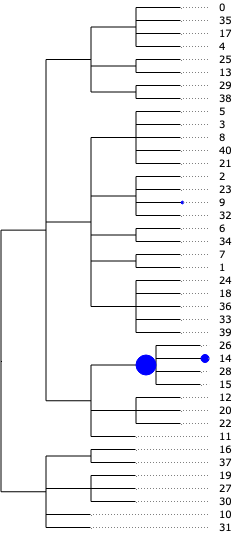

In [27]:
tasccoda_model.plot_draw_effects(
    tasccoda_data,
    modality_key="coda",
    tree="tree",
    covariate="condition[T.Salmonella]",
    show_leaf_effects=False,
    show_legend=False,
)

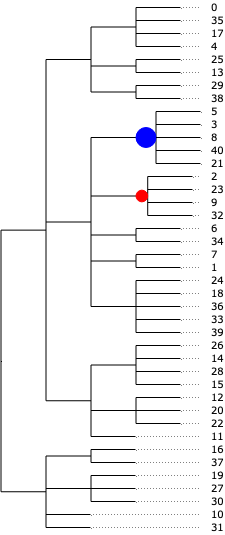

In [28]:
tasccoda_model.plot_draw_effects(
    tasccoda_data,
    modality_key="coda",
    tree="tree",
    covariate="condition[T.Hpoly.Day3]",
    show_leaf_effects=False,
    show_legend=False,
)

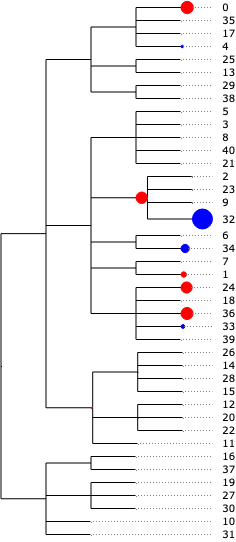

In [29]:
tasccoda_model.plot_draw_effects(
    tasccoda_data,
    modality_key="coda",
    tree="tree",
    covariate="condition[T.Hpoly.Day10]",
    show_leaf_effects=False,
    show_legend=False,
)

Alternatively, effects on internal nodes can also be translated through the tree onto the cell type level, allowing for a calculation of log-fold changes like in scCODA.
To visualize the log-fold changes of the cell types, we do the same plots as for scCODA, inspired by "High-resolution single-cell atlas reveals diversity and plasticity of tissue-resident neutrophils in non-small cell lung cancer"{cite}`Salcher2022`.

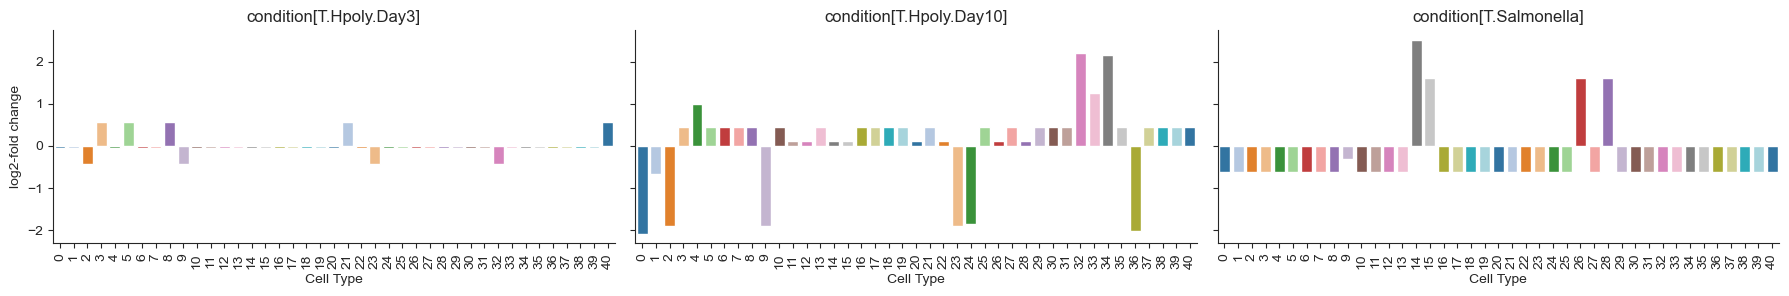

In [30]:
tasccoda_model.plot_effects_barplot(
    tasccoda_data, modality_key="coda", covariates="condition"
)

Another insightful representation can be gained by plotting the effect sizes for each condition on the UMAP embedding, and comparing it to the cell type assignments:

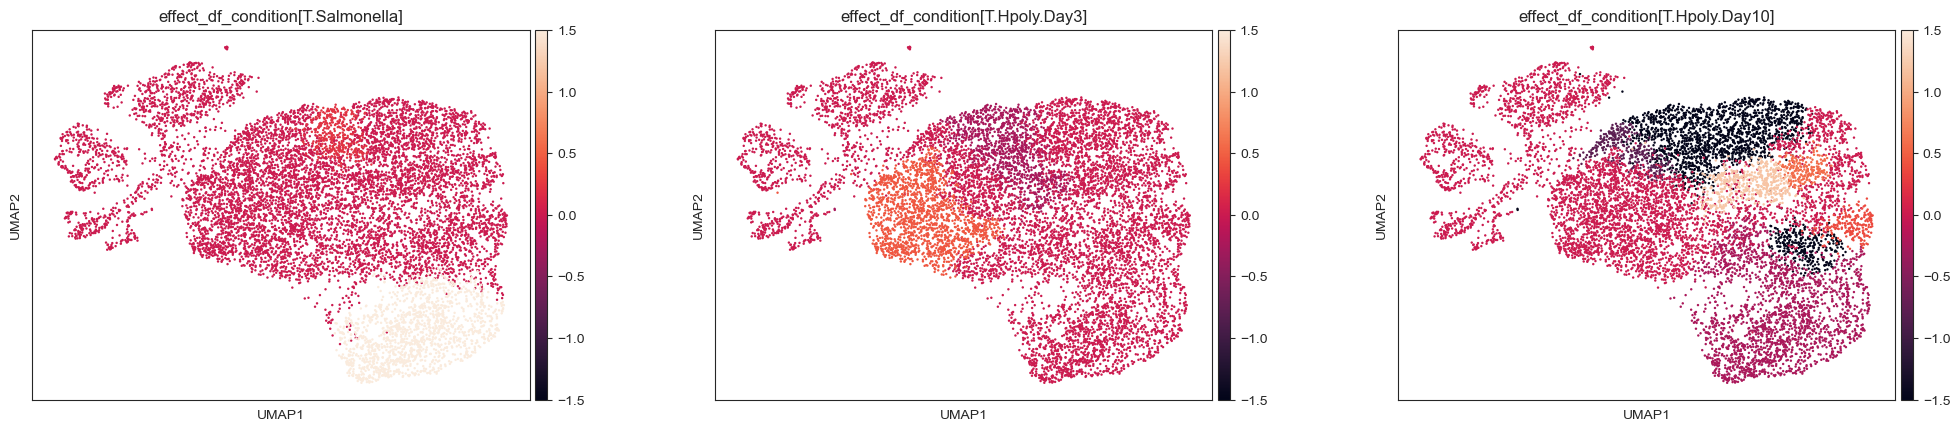

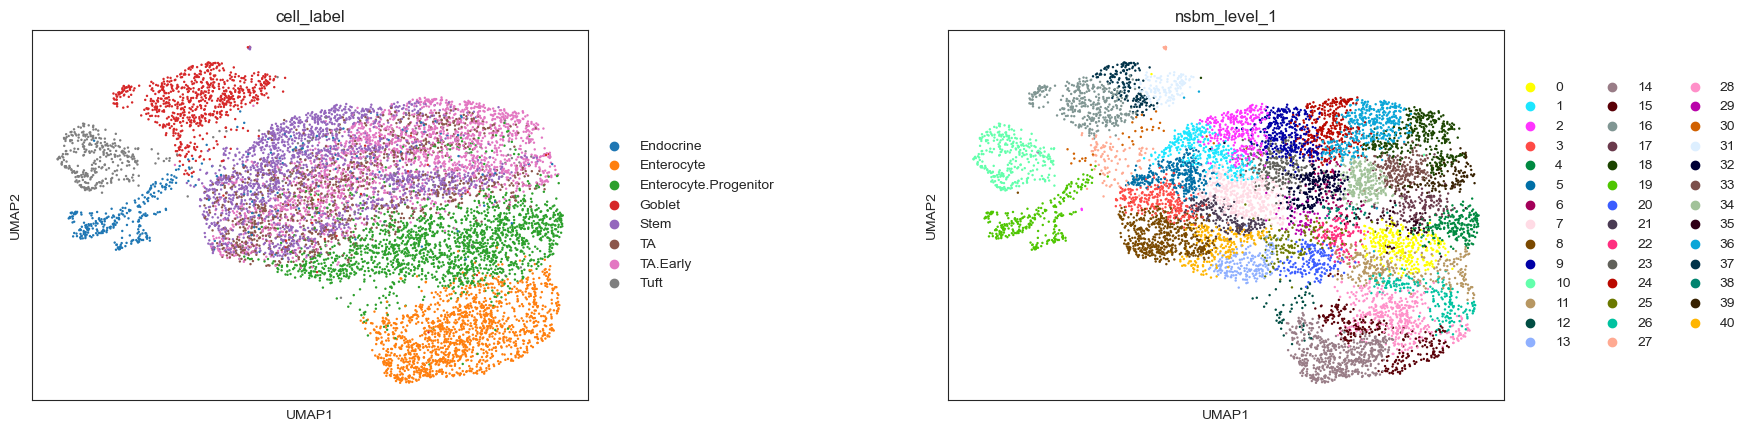

In [31]:
kwargs = {"ncols": 3, "wspace": 0.25, "vcenter": 0, "vmax": 1.5, "vmin": -1.5}
tasccoda_model.plot_effects_umap(
    tasccoda_data,
    effect_name=[
        "effect_df_condition[T.Salmonella]",
        "effect_df_condition[T.Hpoly.Day3]",
        "effect_df_condition[T.Hpoly.Day10]",
    ],
    cluster_key="nsbm_level_1",
    **kwargs,
)
sc.pl.umap(
    tasccoda_data["rna"], color=["cell_label", "nsbm_level_1"], ncols=2, wspace=0.5
)

The results are very similar to scCODA's findings:
- For the Salmonella infection, we get an aggregated increase in clusters that approximately represent Enterocytes in the cell type clustering. This increase is even stronger for cluster 12, as indicated by the additional positive effect on the leaf level
- For the Heligmosomoides polygyrus infection, we get no credible changes after 3 days. After 10 days, we pick up decreases in clusters that contain Stem- and transit-amplifying cells, as well as a less strong decrease of Enterocytes and Enterocyte progenitors, which was also picked up by scCODA.

## Without labeled clusters

It is not always possible or practical to use precisely labeled clusters such as cell-type definitions, especially when we are interested in studying transitional states between cell type clusters, such as during developmental processes, or when we expect only a subpopulation of a cell type to be affected by the condition of interest. In such cases, determining compositional changes based on known annotations may not be appropriate. 

A set of methods exist to detect compositional changes occurring in subpopulations of cells smaller than the cell type clusters, usually defined starting from a k-nearest neighbor (KNN) graph computed from similarities in the same low dimensional space used for clustering. 

- DA-seq computes, for each cell, a score based on the relative prevalence of cells from both biological states in the cell’s neighborhood, using a range of k values{cite}`Zhao2021`. The scores are used as input for a logistic classifier to predict the biological condition of each cell. 
- Milo assigns cells to partially overlapping neighborhoods on the KNN graph, then differential abundance (DA) testing is performed modelling cell counts with a generalized linear model (GLM) {cite}`Dann2022`. 
- MELD calculates a relative likelihood estimate of observing each cell in every condition using graph-based density estimate{cite}`Burkhardt2021`. 

These methods have unique strengths and weaknesses. Because it relies on logistic classification, DA-seq is designed for pairwise comparisons between two biological conditions, but can't be applied to test for differences associated with a continuous covariate (such as age or timepoints). DA-seq and Milo use the variance in the abundance statistic between replicate samples of the same condition to estimate the significance of the differential abundance, while MELD doesn't use this information. While considering consistency across replicates reduces the number of false positives driven by one or a few samples, all KNN-based methods are sensitive to a loss of information if the conditions of interest and confounders, defined by technical or experimental sources of variation, are strongly correlated. The impact of confounders can be mitigated using batch integration methods before KNN graph construction and/or incorporating the confounding covariates in the model for DA testing, as we discuss further in the example below. Another limitation of KNN-based methods to bare in mind is that cells in a neighborhood may not necessarily represent a specific, unique biological subpopulation, because a cellular state may span over multiple neighborhoods. Reducing k for the KNN graph or constructing a graph on cells from a particular lineage of interest can help mitigate this issue and ensure the predicted effects are robust to the choice of parameters and to the data subset used{cite}`Dann2022`. 

Generally, if large differences are apparent in large clusters by visualization or the imbalances between cell types are of interest, direct analysis with cell-type aware methods, such as scCODA, might be more suitable. KNN-based methods are more powerful when we are interested in differences in cell abundances that might appear in transitional states between cell types or in a specific subset of cells of a given cell type.

We will now apply Milo to the Haber dataset to try to find over- or underrepresented neighborhoods of cells upon infection.

Milo is available as [miloR](https://github.com/MarioniLab/miloR) for R users and in [Pertpy](https://github.com/theislab/pertpy) for Python users in the scverse ecosystem. In the following demonstration, we will use milo which is easiest to use with our AnnData object due to its scverse compatibility. Be aware that milo in its current state also requires a working [edgeR](https://bioconductor.org/packages/release/bioc/html/edgeR.html) installation.

To perform DA analysis with Milo, we need to construct a KNN graph that is representative of the biological similarities between cells, as we do when performing clustering or UMAP visualization of a single-cell dataset. This means (A) building a common low-dimensional space for all samples and (B) minimizing cell-cell similarities driven by technical factors (i.e. batch effects).

We first use the standard scanpy workflow for dimensionality reduction to qualitatively assess whether we see a batch effect in this dataset.

In [3]:
milo = pt.tl.Milo()
adata = pt.dt.haber_2017_regions()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 9842 × 15215
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label'
    milo:	0 x 0

In [4]:
# use logcounts to calculate PCA and neighbors
adata.layers["counts"] = adata.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers["counts"]).copy()
adata.X = adata.layers["logcounts"].copy()

sc.pp.highly_variable_genes(
    adata, n_top_genes=3000, subset=False
)  # 3k genes as used by authors for clustering

sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


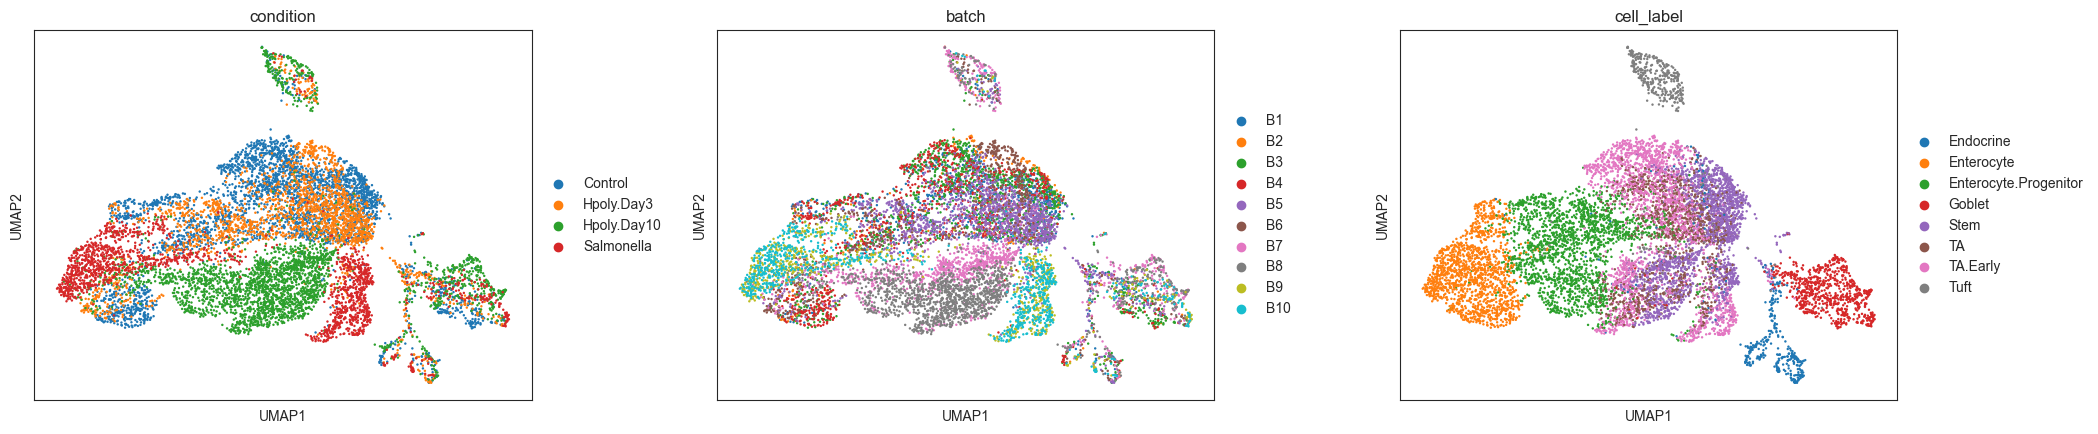

In [5]:
sc.pl.umap(adata, color=["condition", "batch", "cell_label"], ncols=3, wspace=0.25)

While cell type clusters are broadly captured, we can see residual separation between batches, also for replicates of the same treatment. If we define neighbourhoods on this KNN graph we might have a large fraction of neighbourhoods containing cells from just one or a few batches. This could introduce false negatives, if the variance in number of cells between replicates is too low (e.g. 0 cells for all replicates) or too high (e.g. all zero cells except for one replicate with a large number of cells), but also false positives, especially when, like in this case, the number of replicates per condition is low. 

To minimize these errors, we apply the scVI method to learn a batch-corrected latent space, as introduced in the [integration chapter](). 

In [ ]:
import scvi

adata_scvi = adata[:, adata.var["highly_variable"]].copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key="batch")
model_scvi = scvi.model.SCVI(adata_scvi)
max_epochs_scvi = int(np.min([round((20000 / adata.n_obs) * 400), 400]))
model_scvi.train(max_epochs=max_epochs_scvi)
adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

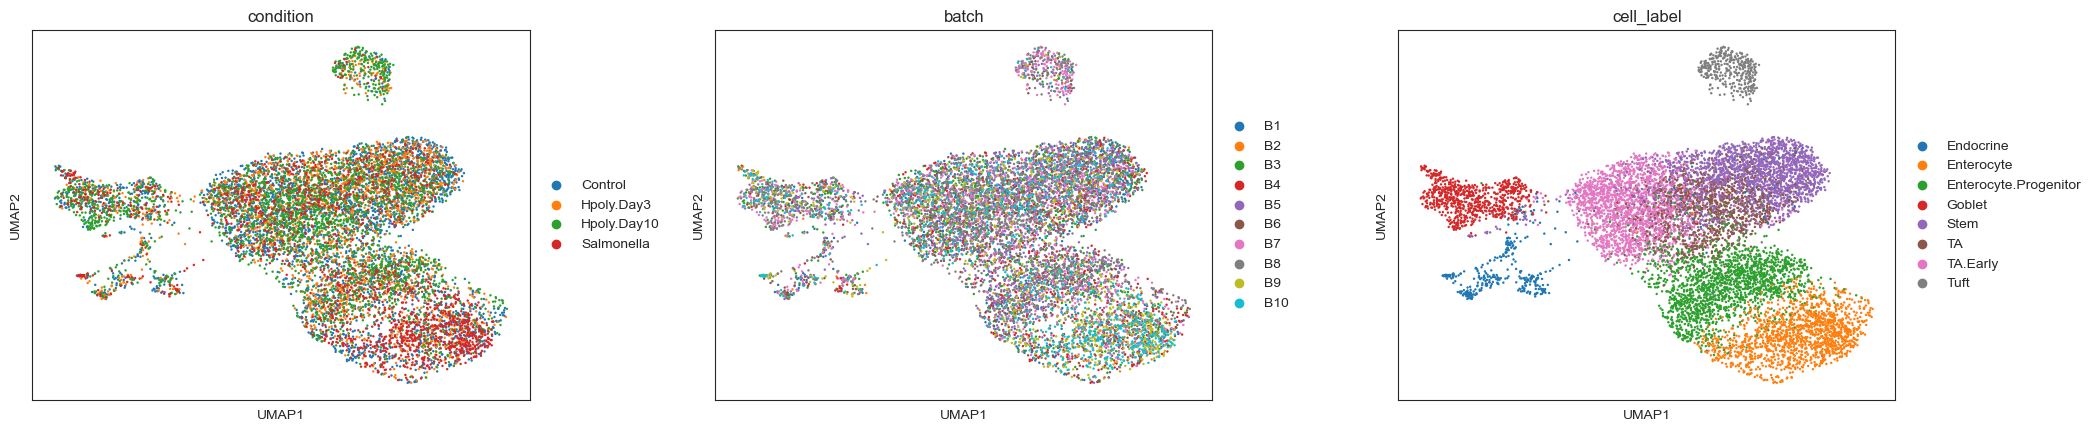

In [ ]:
sc.pl.umap(adata, color=["condition", "batch", "cell_label"], ncols=3, wspace=0.25)

Here we can see much better mixing between batches and cell labels form much more uniform clusters.

```{admonition} Will batch correction remove biological differences between conditions?

This really boils down to good experimental design. In an ideal set-up replicates from the same condition will be processed in different batches. This allows to estimate technical differences more accurately and possibly also incorporate the batch as a confounder in the linear model for differential abundance analysis (see below), to further minimize false positives. When, like in this example, batches are confounded with the biological condition of interest, we have to recognize that while we might be minimizing false positives, the rate of false negatives might also increase. The analyst can decide which type of error is more detrimental depending on the dataset and purpose of the differential abundance analysis.
```

### Define neighbourhoods

Milo is a KNN-based model, where cell abundance is quantified on neighbourhoods of cells. In Milo, a neighbourhood is defined as the group of cells connected by an edge to the same cell (_index cell_) in an undirected KNN graph. While we could in principle have one neighbourhood for each cell in the graph, this would be inefficient and significantly increase the multiple testing burden. Therefore Milo samples a refined set of cells as index cells for neighbourhoods, starting from a random sample of a fraction of cells. The initial proportion can be specified using the `prop` argument in the `milo.make_nhoods` function. As by default, we recommend using `prop=0.1` (10% of cells) and to reduce to 5% or 2% to increase scalability on large datasets (> 100k cells).

If no `neighbors_key` parameter is specified, Milo uses the neighbours from `.obsp`. Therefore, ensure that `sc.pp.neighbors` was run on the correct representation, i.e. an integrated latent space if batch correction was required.

In [ ]:
milo.make_nhoods(mdata, prop=0.1)

Now the binary assignment of cells to neighbourhood is stored in `adata.obsm['nhoods']`. Here we can see that, as expected, the number of neighbourhoods should be less or equal to the number of cells in the graph times the `prop` parameter. In this case, less or equal than 984 neighbourhoods. 

In [ ]:
adata.obsm["nhoods"]

<9842x847 sparse matrix of type '<class 'numpy.float32'>'
	with 22864 stored elements in Compressed Sparse Row format>

At this point we need to check the median number of cells in each neighbourhood, to make sure the neighbourhoods contain enough cells to detect differences between samples.

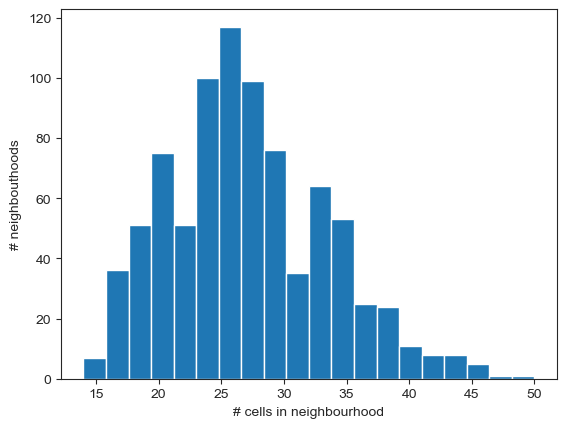

In [ ]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [ ]:
np.median(nhood_size)

26.0

We expect the minimum number of cells to be equal to the k parameter used during graph construction (k=10 in this case). To increase the statistical power for DA testing, we need a sufficient number of cells from all samples in the majority of the neighbourhoods. We can use the following rule of thumb: to have a median of 3 cells from each sample in a neighbourhood, the number of cells in a neighbourhood should be at least 3 times the number of samples. In this case, we have data from 10 samples. If we want to have on average 3 cells from each sample in a neighbourhood, the minimum number of cells should be 30. 

Based on the plot above, we have a large number of neighbourhoods with less than 30 cells, which could lead to an underpowered test. To solve this, we just need to recompute the KNN graph using `n_neighbors=30`. To distinguish this KNN graph used for neighbourhood-level DA analysis from the graph used for UMAP building, we will store this as a distinct graph in `adata.obsp`.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_scVI", key_added="milo")
milo.make_nhoods(mdata, neighbors_key="milo", prop=0.1)

Let's check that the distribution of neighbourhood sizes has shifted.

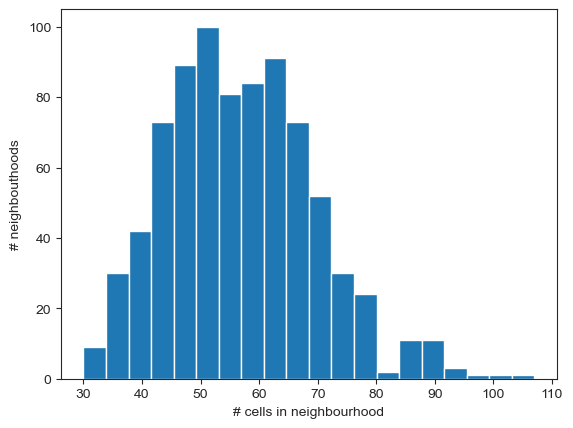

In [ ]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

### Count cells in neighbourhoods

In the next step, Milo counts cells belonging to each of the samples (here identified by the `batch` column in `adata.obs`).

In [ ]:
milo.count_nhoods(mdata, sample_col="batch")

MuData object with n_obs × n_vars = 9842 × 15215
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'pca', 'neighbors', 'umap', 'condition_colors', 'batch_colors', 'cell_label_colors', 'nhood_neighbors_key', 'milo'
      obsm:	'X_pca', 'X_umap', 'X_scVI', 'nhoods'
      varm:	'PCs'
      layers:	'counts', 'logcounts'
      obsp:	'distances', 'connectivities', 'milo_distances', 'milo_connectivities'
    milo_compositional:	10 x 808
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

This stores a neighbourhood-level AnnData object, where `nhood_adata.X` stores the number of cells from each sample in each neighbourhood.

In [ ]:
mdata["milo"]

AnnData object with n_obs × n_vars = 10 × 808
    var: 'index_cell', 'kth_distance'
    uns: 'sample_col'

We can verify that the average number of cells per sample times the number of samples roughly corresponds to the number of cells in a neighbourhood.

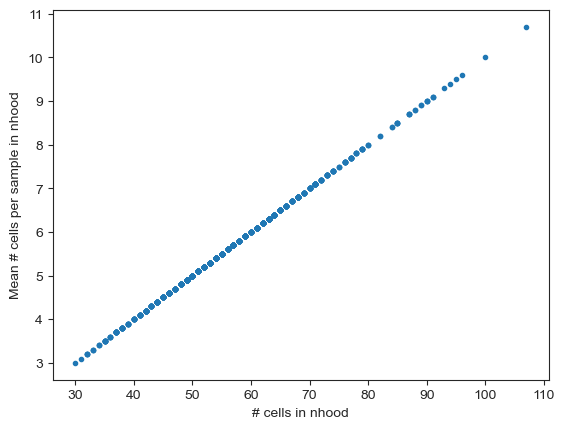

In [ ]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

### Run differential abundance test on neighbourhoods

Milo uses edgeR's QLF test to test if there are statistically significant differences between the number of cells from a condition of interest in each neighborhood. 

Here we are interested in detecting in which neighbourhoods there is a significant increase or decrease of cells in response to infection. Since the `condition` covariate stores many different types of infection, we need to specify which conditions we need to contrast in our differential abundance test (following a convention used in R, by default the last level of the covariate against the rest will be used, in this case Salmonella vs rest). To specify the comparison, we use [the syntax used for GLMs in R](https://genomicsclass.github.io/book/pages/expressing_design_formula.html).

Let's first test for differences associated with Salmonella infection.

In [ ]:
milo.da_nhoods(
    mdata, design="~condition", model_contrasts="conditionSalmonella-conditionControl"
)
milo_results_salmonella = mdata["milo"].obs.copy()
milo_results_salmonella

condition batch
B1       Control    B1
B2       Control    B2
B3       Control    B3
B4       Control    B4
B5    Hpoly.Day3    B5
B6    Hpoly.Day3    B6
B7   Hpoly.Day10    B7
B8   Hpoly.Day10    B8
B9    Salmonella    B9
B10   Salmonella   B10

For each neighbourhood, we calculate a set of statistics. The most important ones to understand are:
- **log-Fold Change (logFC):** this represents the effect size of the difference in cell abundance and corresponds to the coefficient associated with the condition of interest in the GLM. If logFC > 0 the neighbourhood is enriched in cells from the condition of interest, if logFC < 0 the neighbourhood is depleted in cells from the condition of interest. 
- **Uncorrected p-value (PValue):** this is the p-value for the QLF test before multiple testing correction.
- **SpatialFDR:** this is the p-value adjusted for multiple testing to limit the false discovery rate. This is calculated adapting the weighted Benjamini-Hochberg (BH) correction introduced by Lun et al {cite}`lun2017`, which accounts for the fact that because neighbourhoods are partially overlapping (i.e. one cell can belong to multiple neighbourhoods) the DA tests on different neighbourhoods are not completely independent. In practice, the BH correction is weighted by the reciprocal of the distance to the k-th nearest neighbor to the index cell (stored in `kth_distance`), which is used as a proxy for the amount of overlap with other neighbourhoods. You might notice that the SpatialFDR values are always lower or equal to the FDR values, calculated with a conventional BH correction.

Before any exploration and interpretation of the results, we can visualize these statistics with a set of diagnostics plots to sanity check our statistical test:

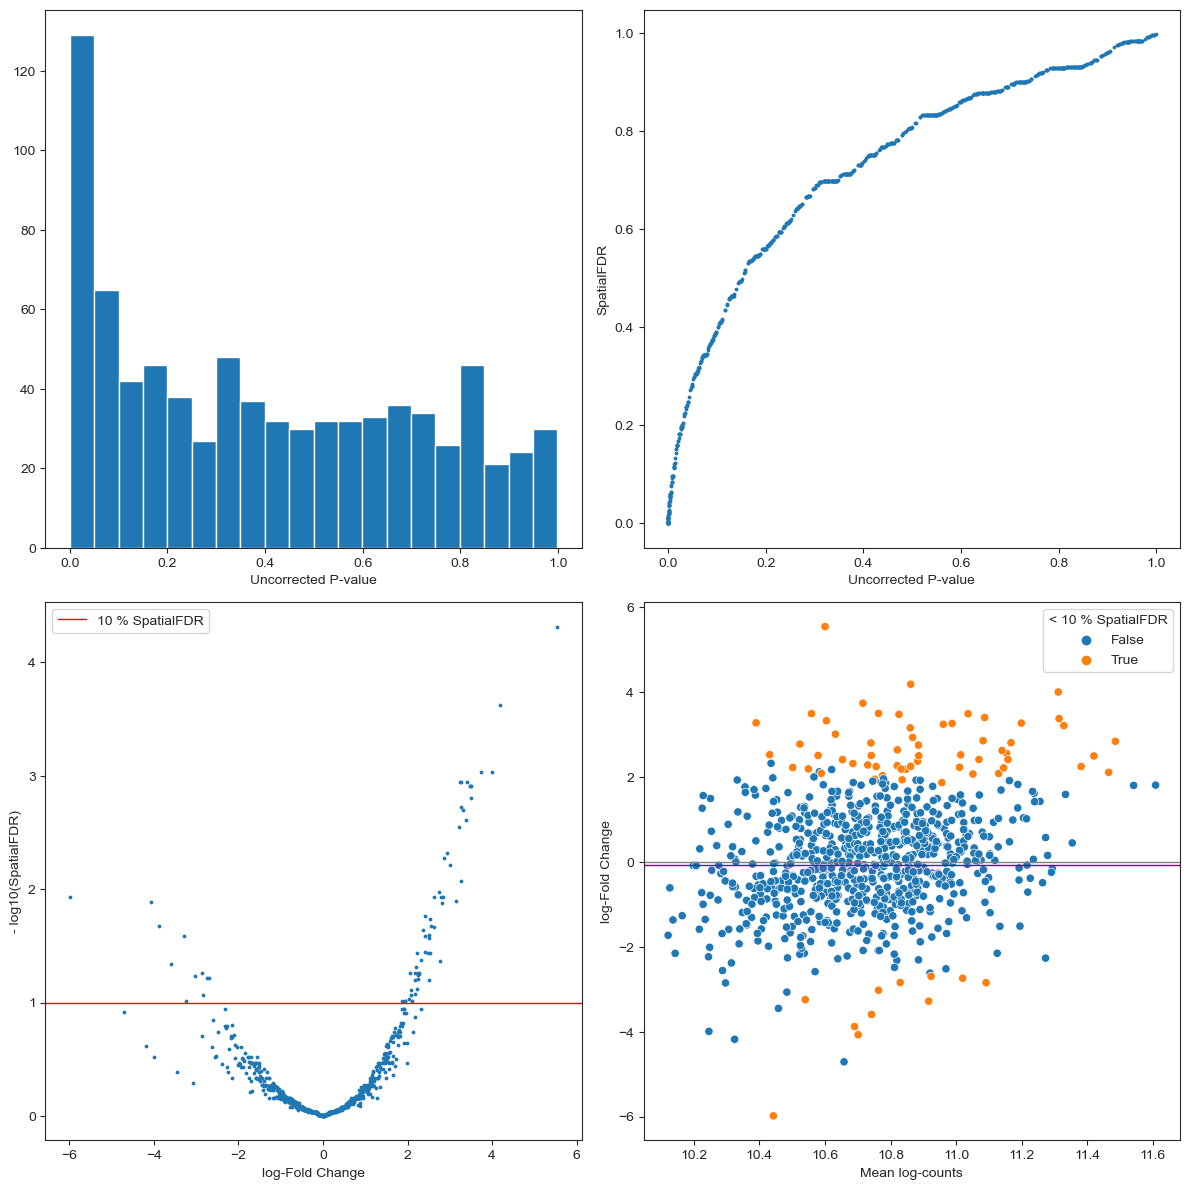

In [ ]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):
        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

1. The **P-value histogram** shows the distribution of P-values before multiple testing correction. By definition, we expect the p-values under the null hypothesis (> significance level) to be uniformly distributed, while the peak of p-values close to zero represents the significant results. This gives you an idea of how conservative your test is, and it might help to spot early some pathological cases. For example, if the distribution of P-values looks bimodal, with a second peak close to 1, this might indicate that you have a large number of neighbourhoods with no variance between replicates of one condition (e.g. all replicates from one condition have 0 cells) which might indicate a residual batch effect or that you need to increase the size of neighbourhoods; if the p-value histogram is left-skewed this might indicate a [confounding covariate](https://github.com/MarioniLab/miloR/issues/220#issuecomment-1140812805) has not been accounted for in the model. For other pathological cases and possible interpretations see [this blogpost](http://varianceexplained.org/statistics/interpreting-pvalue-histogram/).
2. For each neighbourhood we plot the uncorrected P-Value VS the p-value controlling for the Spatial FDR. Here we expect the adjusted p-values to be larger (so points above the diagonal). If the FDR correction is especially severe (i.e. many values close to 1) this might indicate a pathological case. You might be testing on too many neighbourhoods (you can reduce `prop` in `milo.make_nhoods`) or there might be too much overlap between neighbourhoods (you might need to decrease _k_ when constructing the KNN graph).
3. The **volcano plot** gives us an idea of how many neighbourhoods show significant DA after multiple testing correction ( - log(SpatialFDR) > 1) and shows how many neighbourhoods are enriched or depleted of cells from the condition of interest.  
4. The **MA plot** shows the dependency between average number of cells per sample and the log-Fold Change of the test. In a balanced scenario, we expect points to be concentrated around logFC = 0, otherwise the shift might indicate a strong imbalance in average number of cells between samples from different conditions. For more tips on how to interpret the MA plot see https://github.com/MarioniLab/miloR/issues/208.

After sanity check, we can visualize the DA results for each neighbourhood by the position of the index cell on the UMAP embedding, to qualitatively assess which cell types may be most affected by the infection.

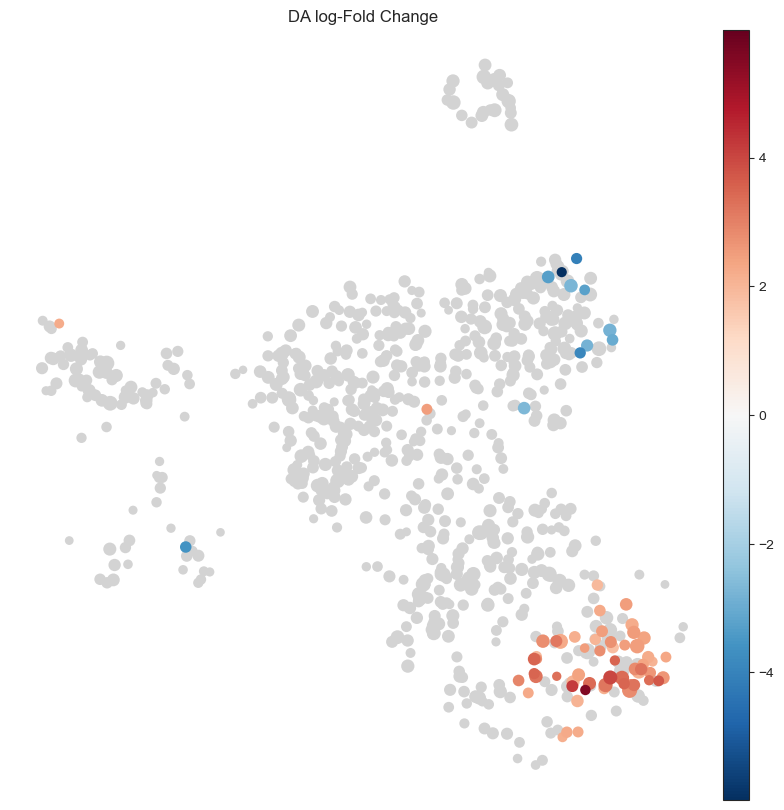

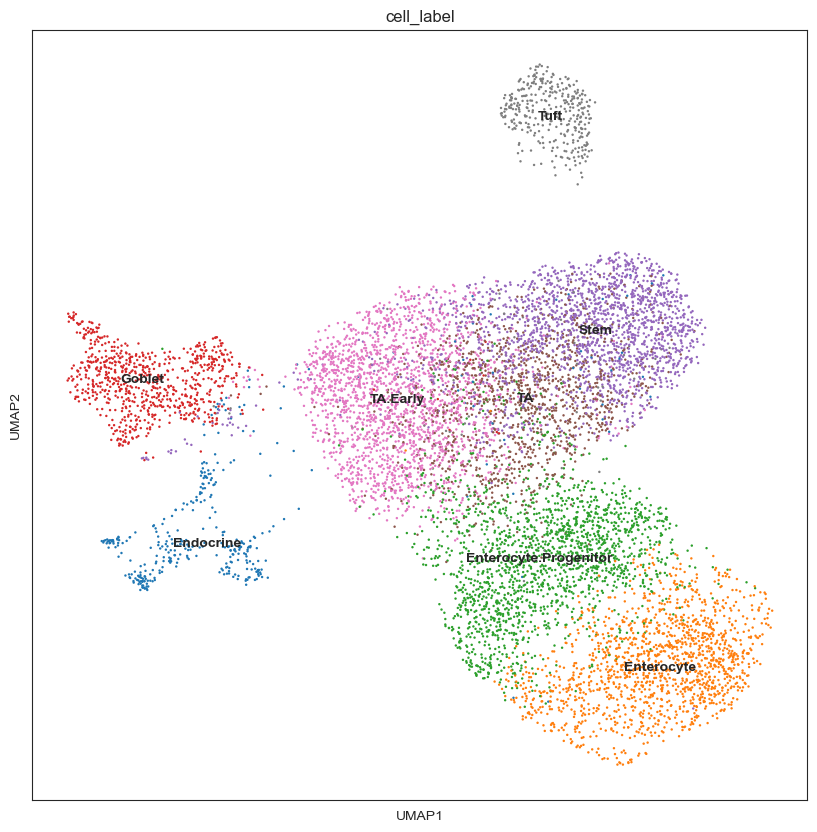

In [ ]:
milo.build_nhood_graph(mdata)
with matplotlib.rc_context({"figure.figsize": [10, 10]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=5, plot_edges=False)
    sc.pl.umap(mdata["rna"], color="cell_label", legend_loc="on data")

This shows a set of neighbourhoods enriched upon Salmonella infection corresponding to mature enterocytes, and a depletion in a subset of stem cell neighbourhoods. For interpretation of results, it's often useful to annotate neighbourhoods by the cell type cluster that they overlap with.

In [ ]:
milo.annotate_nhoods(mdata, anno_col="cell_label")
# Define as mixed if fraction of cells in nhood with same label is lower than 0.75

mdata["milo"].var.loc[
    mdata["milo"].var["nhood_annotation_frac"] < 0.75, "nhood_annotation"
] = "Mixed"

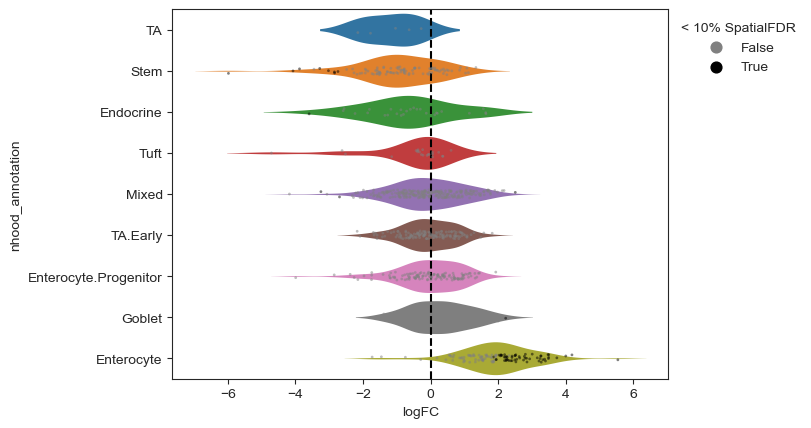

In [ ]:
milo.plot_da_beeswarm(mdata)
plt.show()

```{admonition} What about the compositional effect?

Comparing the Milo results to the scCODA results, here we identify a strong enrichment upon _Salmonella_ infection in the Enterocytes, but also a depletion in a subset of Stem cells, similarly to what the original authors reported{cite}`comp:Haber2017`. Although we don't have a ground truth to verify whether the decrease in abundance of stem cells is real, it's important to note that the GLM in Milo doesn't explicitly model the compositional nature of cell abundances in neighborhoods, so in theory the results could be affected by compositional biases. In practice, performing a test on a large number of neighbourhoods alleviates this issue, since the effect in the opposite direction is distributed across thousands of neighborhoods rather than tens of cell types. Additionally, the test used in Milo uses the trimmed mean of M values normalization method (TMM normalization {cite}`comp:Robinson2010`) to estimate normalization factors robust to compositional differences across samples. In this particular example, residual compositional effects might be explained by (A) the relatively small number of neighborhoods (< 1000), (B) the very large effect size in Enterocyte neighbourhoods or (C) the very small number of replicates per condition.   
```

Of note, the GLM framework used by Milo allows to test for cell enrichment/depletion also for continuous covariates. We demonstrate this by testing for differential abundance along the _Heligmosomoides polygyrus_ infection time course.

In [ ]:
## Turn into continuous variable
mdata["rna"].obs["Hpoly_timecourse"] = (
    mdata["rna"]
    .obs["condition"]
    .cat.reorder_categories(["Salmonella", "Control", "Hpoly.Day3", "Hpoly.Day10"])
)
mdata["rna"].obs["Hpoly_timecourse"] = mdata["rna"].obs["Hpoly_timecourse"].cat.codes

## Here we exclude salmonella samples
test_samples = (
    mdata["rna"]
    .obs.batch[mdata["rna"].obs.condition != "Salmonella"]
    .astype("str")
    .unique()
)
milo.da_nhoods(mdata, design="~ Hpoly_timecourse", subset_samples=test_samples)

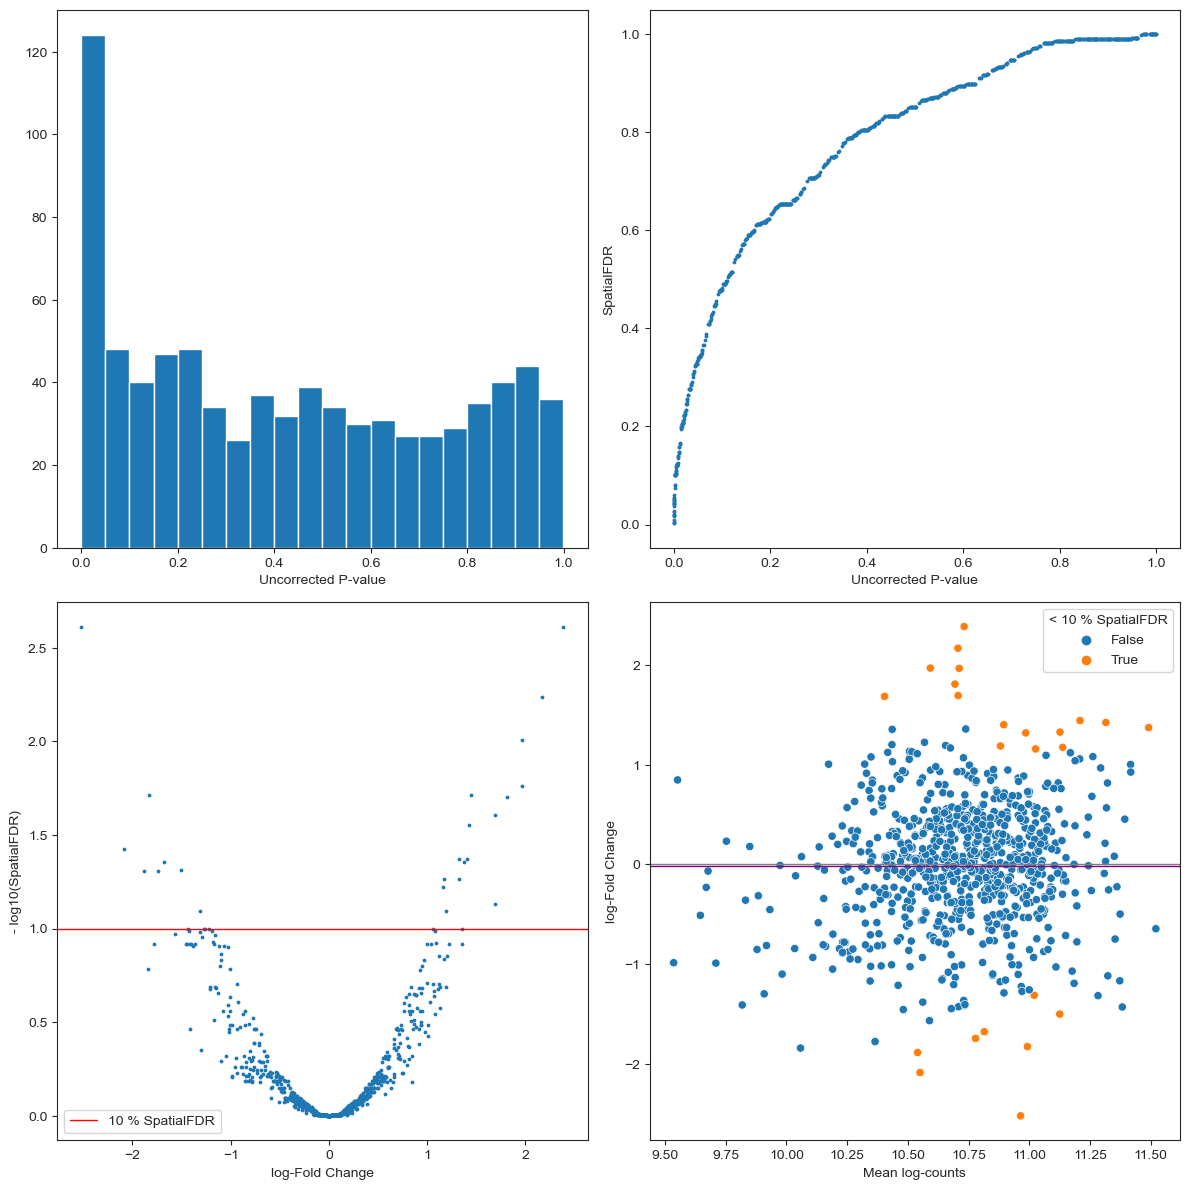

In [ ]:
plot_milo_diagnostics(mdata)

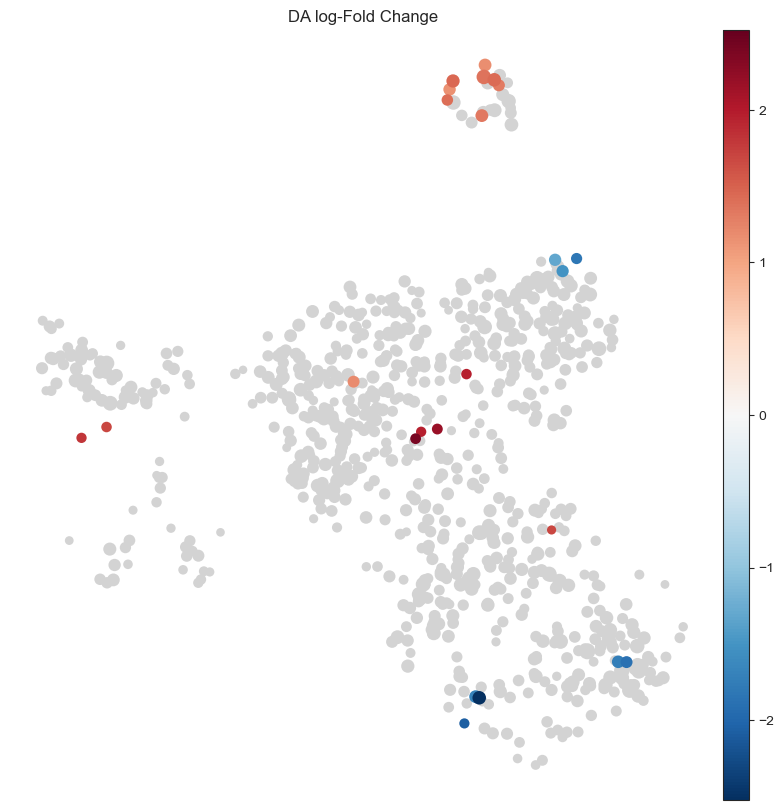

In [ ]:
with matplotlib.rc_context({"figure.figsize": [10, 10]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=5, plot_edges=False)

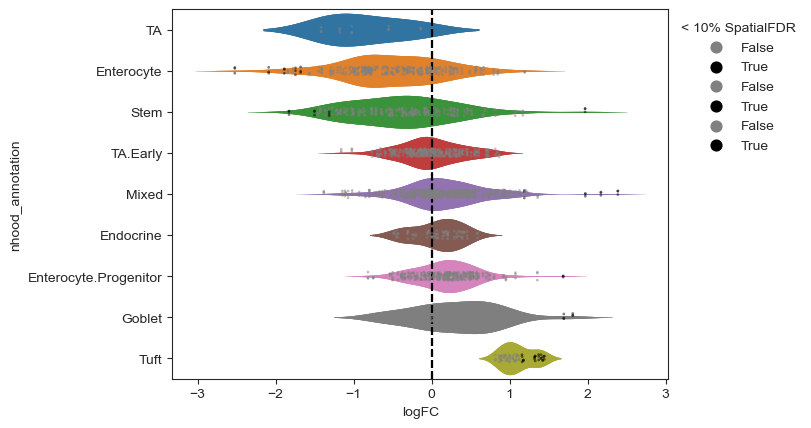

In [ ]:
milo.plot_da_beeswarm(mdata)
plt.show()

We can verify that the test captures a linear increase in cell numbers across the time course by plotting the number of cells per sample by condition in neighborhoods where significant enrichment or depletion was detected.

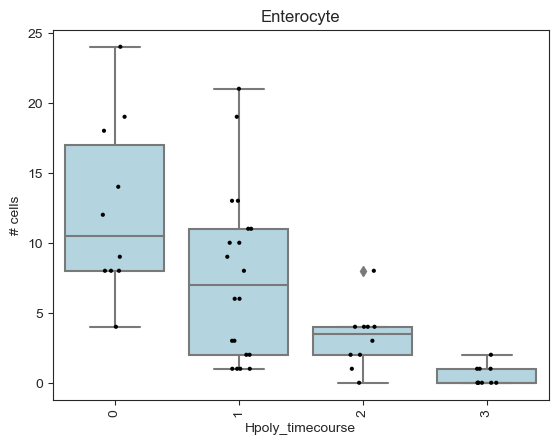

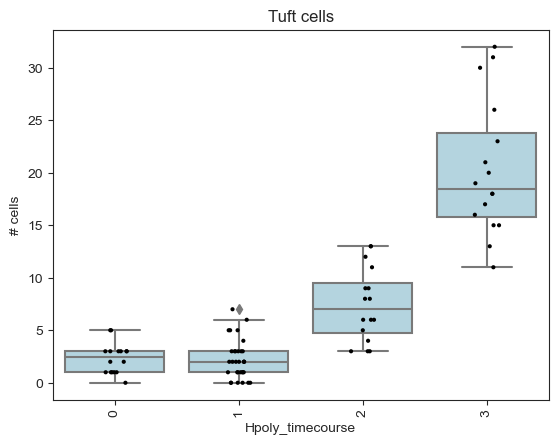

In [ ]:
entero_ixs = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1)
    & (mdata["milo"].var["logFC"] < 0)
    & (mdata["milo"].var["nhood_annotation"] == "Enterocyte")
]

plt.title("Enterocyte")
milo.plot_nhood_counts_by_cond(
    mdata, test_var="Hpoly_timecourse", subset_nhoods=entero_ixs
)
plt.show()


tuft_ixs = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1)
    & (mdata["milo"].var["logFC"] > 0)
    & (mdata["milo"].var["nhood_annotation"] == "Tuft")
]
plt.title("Tuft cells")
milo.plot_nhood_counts_by_cond(
    mdata, test_var="Hpoly_timecourse", subset_nhoods=tuft_ixs
)
plt.show()

Interestingly the DA test on the neighbourhoods detects an enrichment upon infection in Tuft cells and in a subset of goblet cells. We can characterize the difference between cell type subpopulations enriched upon infection by examining the mean gene expression profiles of cells in neighbourhoods. For example, if we take the neighbourhoods of Goblet cells, we can see that neighbourhoods enriched upon infection display a higher expression of Retnlb, which is a gene implicated in anti-parasitic immunity {cite}`comp:Haber2017`.   

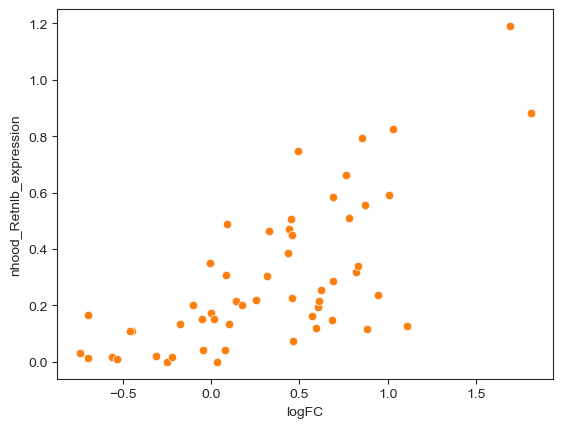

In [ ]:
## Compute average Retnlb expression per neighbourhood
# (you can add mean expression for all genes using milo.utils.add_nhood_expression)
mdata["rna"].obs["Retnlb_expression"] = (
    mdata["rna"][:, "Retnlb"].layers["logcounts"].toarray().ravel()
)
milo.annotate_nhoods_continuous(mdata, "Retnlb_expression")
# milo.annotate_nhoods(mdata, "Retnlb_expression")

## Subset to Goblet cell neighbourhoods
nhood_df = mdata["milo"].var.copy()
nhood_df = nhood_df[nhood_df["nhood_annotation"] == "Goblet"]

sns.scatterplot(data=nhood_df, x="logFC", y="nhood_Retnlb_expression")
plt.show()

> **Accounting for confounding covariates:** several confounding factors might affect cell abundances and proportions other than our condition of interest. For example, different set of samples might have been processed or sequenced in the same batch, or a set of samples could contain cells FAC-sorted using different markers to enrich a subset of populations of interest. As long as these factors are not completely correlated with the condition of interest, we can include these covariates in the model used for differential abundance testing, to estimate differential abundance associated with the condition of interest, while minimizing differences explained by the confounding factors. In Milo, we can express this type of test design using the syntax `~ confounder + condition`.

In [ ]:
## Make dummy confounder for the sake of this example
nhood_adata = mdata["milo"].copy()
conf_dict = dict(
    zip(
        nhood_adata.obs_names,
        rng.choice(["group1", "group2"], nhood_adata.n_obs),
    )
)
mdata["rna"].obs["dummy_confounder"] = [conf_dict[x] for x in mdata["rna"].obs["batch"]]

milo.da_nhoods(mdata, design="~ dummy_confounder+condition")

In [ ]:
mdata["milo"].var

index_cell  kth_distance  \
0                     B1_AAAGGCCTAAGGCG_Control_Stem      1.304513   
1                 B1_AACACGTGATGCTG_Control_TA.Early      1.335187   
2               B1_AACTTGCTGGTATC_Control_Enterocyte      1.519376   
3               B1_AAGAACGATGACTG_Control_Enterocyte      2.143153   
4    B1_AATTACGAAACAGA_Control_Enterocyte.Progenitor      1.600587   
..                                               ...           ...   
803             B10_TTAGGTCTAGACTC_Salmonella_Goblet      1.547428   
804           B10_TTAGTCACCATGGT_Salmonella_TA.Early      1.348982   
805           B10_TTATGGCTTAACGC_Salmonella_TA.Early      1.357123   
806           B10_TTCATCGACCGTAA_Salmonella_TA.Early      1.313244   
807           B10_TTGAACCTCATTTC_Salmonella_TA.Early      1.333960   

     SpatialFDR    Sig  Nhood_size       nhood_annotation  \
0      0.056105  False        53.0                   Stem   
1      0.938353  False        67.0                  Mixed   
2      0.693653  False        49.0             Enterocyte   
3      0.746709  False        39.0             Enterocyte   
4      0.436180  False        37.0  Enterocyte.Progenitor   
..          ...    ...         ...                    ...   
803    0.400895  False        48.0                 Goblet   
804    0.880493  False        64.0               TA.Early   
805    0.981884  False        51.0               TA.Early   
806    0.908718  False        66.0               TA.Early   
807    0.787177  False        55.0                  Mixed   

     nhood_annotation_frac  nhood_Retnlb_expression     logFC     logCPM  \
0                 0.830189                 0.033807 -3.696119  10.690300   
1                 0.477612                 0.020691 -0.248959  10.926409   
2                 1.000000                 0.000000  0.951949  10.727155   
3                 1.000000                 0.000000  0.879631  10.467676   
4                 0.945946                 0.000000 -2.440105  10.296494   
..                     ...                      ...       ...        ...   
803               1.000000                 0.126426  1.931002  10.566431   
804               0.875000                 0.010830 -0.553709  10.876626   
805               0.862745                 0.000000  0.071987  10.649724   
806               0.787879                 0.021004 -0.403998  10.825716   
807               0.454545                 0.012603  0.774925  10.712952   

            F    PValue       FDR  
0    9.083460  0.002595  0.066143  
1    0.078934  0.778762  0.941976  
2    1.416844  0.233993  0.720537  
3    1.109896  0.292168  0.769131  
4    3.202427  0.073604  0.478744  
..        ...       ...       ...  
803  3.591423  0.058150  0.443255  
804  0.342947  0.558166  0.886244  
805  0.007052  0.933080  0.982928  
806  0.176318  0.674579  0.916060  
807  0.811296  0.367791  0.805382  

[808 rows x 13 columns]

## Key Takeaways

1. If the primary interest lies in compositional changes among known cell-types or states, use scCODA or tascCODA to statistically evaluate changes in abundance.
2. KNN based methods like DA-Seq or MILO should be used if the data does not cluster distinctly, such as during developmental processes, if we are interested in differences in cell abundances that might appear in transitional states between cell types or in a specific subset of cells of a given cell type. 

## Quiz

In [ ]:
%run ../src/lib.py

flip_card(
    "q1",
    "It is tricky to deduce compositional changes visually. Why?",
    "Interpreting compositional changes visually is challenging because shifts in cell type proportions may be subtle or confounded by the high dimensionality and variability inherent in single-cell data, making it difficult to discern significant differences without statistical analysis.",
    back_font_size=15,
)
flip_card(
    "q2",
    "Why is it necessary to interpret cell type ubundances as proportions instead of absolute counts? What are the dangers of not doing so?",
    "Interpreting cell type abundances as proportions rather than absolute counts is essential because the total number of cells can vary between samples; failing to account for this can lead to misleading conclusions, as apparent changes in cell counts might simply reflect differences in sample sizes rather than true biological variations.",
    back_font_size=13,
)
flip_card(
    "q3",
    "In which cases should tools that use cluster information, such as cell types be used, and in which cases tools that do not use cluster information?",
    "Tools that utilize cluster information, such as cell types, are appropriate when distinct clusters are identifiable, allowing for targeted analysis of known populations. Conversely, methods that do not rely on clustering are beneficial when data lacks clear separations, such as during continuous developmental processes, enabling the detection of subtle changes across a spectrum of cell states.",
    back_font_size=12,
)

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: comp
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Johannes Ostner
* Emma Dann
* Lukas Heumos
* Anastasia Litinetskaya

### Reviewers